# IA for HumanForYou

## Membres du groupe
- Thibaut Meslin (Chef de projet)
- Gary Houivet
- Nathan Leroy
- Alaa Taleb

## Contexte
L'entreprise de produits pharmaceutiques HumanForYou basée en Inde emploie environ 4000 personnes. Cependant, chaque année elle subit un turn-over d'environ 15% de ses employés nécessitant de retrouver des profils similaires sur le marché de l'emploi.
La direction trouve que ce niveau de turn-over n'est pas bon pour l'entreprise car :
- Les projets sur lesquels étaient les employés quittant la société prennent du retard ce qui nuit à la réputation de l'entreprise auprès de ses clients et partenaires.
- Un service de ressources humaines de taille conséquente doit être conservé car il faut avoir les moyens de trouver les nouvelles recrues.
- Du temps est perdu à l'arrivée des nouveaux employés car ils doivent très souvent être formés et ont besoin de temps pour devenir pleinement opérationnels dans leur nouvel environnement.

## Données

Dans le cadre de ce projet, notre jeu de données est composé de 5 fichiers :
- general_data.csv
> Cette source de données fournie des données générales sur chaque employé.
Elle contient notamment pour chaque employé : son âge, son genre, son rôle dans l’entreprise, son salaire, etc… 
- manager_survey_data.csv
> La dernière évaluation de chaque employé par son manager.
  Son implication dans son travail ainsi que son niveau de performance annuel est évalué
- employee_survey_data.csv
> Enquête facultative sur la qualité de vie des employés mené en juin 2015.
  Chaque employé ayant participé à l’enquête a évalué : son environnement de travail, sa satisfaction au travail et son équilibre entre sa vie professionnelle et sa vie privée.
- in_time.csv et out_time.csv
> Horaires de travail relevé par la badgeuse dans les locaux de l’entreprise.


## Objectifs

L’objectif de ce projet est de déterminer les facteurs ayant le plus d’influence sur le taux de turn-over dans l’entreprise ainsi que d’apporter des pistes d’amélioration pour mettre fin à ce phénomène récurrent.

L’idée n’est pas de prévoir quels employés sont susceptibles de partir afin de ne plus recruter de candidats similaires dans le futur, ce qui ne serait pas éthique, mais bien de proposer des solutions pour donner envie aux employés susceptibles de partir de rester dans l’entreprise.

## Importation des bibliothèques


In [1]:
import numpy as np # Linear algebra
from statistics import mean # Mean calculation
import os # File management
import math # Math functions
import tqdm # Progress bar
from datetime import datetime # Date and time conversion
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # Plotting
import pandas as pd # Data processing
from scipy.stats import randint # Random integer

from sklearn.model_selection import StratifiedShuffleSplit # Stratified split
from sklearn.preprocessing import StandardScaler # Standard scaler

from sklearn.tree import DecisionTreeClassifier # Decision tree
from sklearn.ensemble import RandomForestClassifier # Random forest
from sklearn.linear_model import LogisticRegression # Logistic regression
from sklearn.model_selection import RandomizedSearchCV # Grid search

from pandas.plotting import scatter_matrix # Scatter matrix
from sklearn.model_selection import cross_val_score, cross_val_predict # Cross validation
from sklearn.metrics import mean_squared_error # Mean squared error
from sklearn.metrics import confusion_matrix # Confusion matrix
from sklearn.metrics import f1_score # F1 score
from sklearn.inspection import permutation_importance # Permutation importance
from sklearn.metrics import roc_curve # ROC curve
from sklearn.metrics import roc_auc_score # ROC AUC score

import warnings # ignorer les warnings inutiles (voir SciPy issue #5998)
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images") # dossier de sauvegarde des figures
DATASET_PATH = os.path.join(PROJECT_ROOT_DIR, "dataset") # dossier avec les données d'entrées

In [3]:
random_state = 42 # Graine de génération aléatoire afin de pouvoir reproduire les résultats à chaque exécution du juptyer notebook

# Data wrangling

### Import des données

In [4]:
def load_data(file, dataset_path=DATASET_PATH):
    csv_path = os.path.join(dataset_path, file)
    return pd.read_csv(csv_path)

#Import des données
general_data = load_data("general_data.csv")
manager_survey_data = load_data("manager_survey_data.csv")
employee_survey_data = load_data("employee_survey_data.csv")
in_time_data = load_data("in_time.csv")
out_time_data = load_data("out_time.csv")

### Verification du dataset

On va dans un premier temps vérifier si le dataset est complet et s'il n'y a pas de valeurs manquantes. On va également vérifier si les données sont cohérentes et si elles sont dans le bon format (numériques) pour pouvoir les traiter.

In [5]:
def check_missing_values(file, name):

    temp_df = pd.DataFrame(file, file.index, file.columns)

    na_count = temp_df.isna().sum().sum()
    empty_count = temp_df.iloc[:, :].eq('').sum().sum()
    total_count = temp_df.count().sum()

    print("Le dataset", name, "contient", total_count, "données")
    print("Valeurs N/A:", na_count, "soit", round(na_count*100/total_count, 3), "% du dataset")
    print("Valeurs nulles:", empty_count, "soit", round(empty_count*100/total_count, 3), "% du dataset \n")

In [6]:
check_missing_values(general_data, "general_data")
check_missing_values(manager_survey_data, "manager_survey_data")
check_missing_values(employee_survey_data, "employee_survey_data")
check_missing_values(in_time_data, "in_time_data")
check_missing_values(out_time_data, "out_time_data")

Le dataset general_data contient 105812 données
Valeurs N/A: 28 soit 0.026 % du dataset
Valeurs nulles: 0 soit 0.0 % du dataset 

Le dataset manager_survey_data contient 13230 données
Valeurs N/A: 0 soit 0.0 % du dataset
Valeurs nulles: 0 soit 0.0 % du dataset 

Le dataset employee_survey_data contient 17557 données
Valeurs N/A: 83 soit 0.473 % du dataset
Valeurs nulles: 0 soit 0.0 % du dataset 

Le dataset in_time_data contient 1046340 données
Valeurs N/A: 109080 soit 10.425 % du dataset
Valeurs nulles: 0 soit 0.0 % du dataset 

Le dataset out_time_data contient 1046340 données
Valeurs N/A: 109080 soit 10.425 % du dataset
Valeurs nulles: 0 soit 0.0 % du dataset 



On remarque que les fichiers *"general_data.csv"*, *"employee_survey_data.csv"*, *"in_time_data.csv"* et *"out_time_data.csv"* possèdent des valeurs manquantes. On va donc devoir traiter ces valeurs afin de rendre le dataset complet et exploitable par la suite. 
Les données manquantes sont sur les colones suivantes :
- *NumCompaniesWorked* & *TotalWorkingYears* --> **28 trous**
- *EnvironmentSatisfaction* & *JobSatisfaction* & *WorkLifeBalance* --> **83 trous**
- Trous correspondant à des absences de badgeage --> **218160 trous au total**

In [7]:
general_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

Certaines colonnes ne sont pas pertinentes pour notre étude comme la colonne *"Over18"* qui ne nous servira pas et dont on peut facilement se passer en regardant les données dans la colonne *"Age"*, ces colonnes seront donc supprimées.

Néanmoins, nous avons fait le choix de garder les colonnes *"Attrition"* et *"Department"* car elles représentent des valeurs importantes pour notre étude. Nous allons donc devoir convertir ces colonnes en données numériques afin de pouvoir les traiter, de même pour la colonne *"BusinessTravel"*.

### Transformation du dataset

Dans un premier temps, nous allons créé de la valeur à partir des fichiers *"in_time_data.csv"* et *"out_time_data.csv"* en calculant le temps de travail de chaque employé. Nous serons donc en mesure de calculer son temps de travail moyen sur toute la période fournie dans le dataset. Cette moyenne sera enregistrée dans une nouvelle colonne *"AverageWorkTime"*.

In [8]:
def mean_work_time():
    daily_work_time = []
    total_work_avg = []
    for user in tqdm.tqdm(range(0, len(in_time_data))): # Pour chaque utilisateur
        for data in range(1, len(in_time_data.columns)): # Pour chaque jour
            if (pd.isna(out_time_data.iloc[user, data])) or (pd.isna(in_time_data.iloc[user, data])): #Si l'employé n'était pas présent ce jour là
                continue
            else:
                daily_work_time.append(
                    (datetime.strptime(out_time_data.iloc[user, data], '%Y-%m-%d %H:%M:%S') - datetime.strptime(in_time_data.iloc[user, data], '%Y-%m-%d %H:%M:%S')).total_seconds() / 3600 # On calcule le temps travaillé en heures et on l'ajoute au tableau
                )
        total_work_avg.append(round(mean(daily_work_time), 2)) # On fait la moyenne des heures travaillés et on l'arrondie à 2 chiffres après la virgule
        daily_work_time.clear() # On vide le tableau pour le prochain employé
    in_time_data["MeanWorkTime"] = total_work_avg # On ajoute le résultat dans le dataframe

mean_work_time()
in_time_data["MeanWorkTime"]

100%|██████████| 4410/4410 [01:26<00:00, 50.79it/s]


0       7.37
1       7.72
2       7.01
3       7.19
4       8.01
        ... 
4405    8.52
4406    6.09
4407    7.71
4408    9.49
4409    6.99
Name: MeanWorkTime, Length: 4410, dtype: float64

In [9]:
# Suppression des jours non travaillés du jeu de données horaires (Weekends et jours fériés)
def remove_holidays():
    in_time_data.dropna(axis=1, how='all', inplace=True)

print("Nombre de colonnes avant suppression des jours fériés:", in_time_data.shape[1], "--> NA totaux :", in_time_data.isna().sum().sum())
remove_holidays()
print("Nombre de colonnes après suppression des jours fériés:", in_time_data.shape[1], "--> NA restant :", in_time_data.isna().sum().sum())

# Compter le nombre de "N/A" dans chaque ligne et l'ajouter comme nouvelle colonne "N/A_count"
in_time_data["AbsentCount"] = in_time_data.isna().sum(axis=1)
in_time_data["AbsentCount"]

Nombre de colonnes avant suppression des jours fériés: 263 --> NA totaux : 109080
Nombre de colonnes après suppression des jours fériés: 251 --> NA restant : 56160


0       17
1       13
2        7
3       14
4        4
        ..
4405     6
4406     8
4407    18
4408     8
4409    17
Name: AbsentCount, Length: 4410, dtype: int64

In [10]:
# Remplacer les catégories par des valeurs numériques
general_data['Attrition'] = general_data['Attrition'].replace({'No': 0, 'Yes': 1})
general_data['BusinessTravel'] = general_data['BusinessTravel'].replace({'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2})
general_data['Department'] = general_data['Department'].replace({'Human Resources': 0, 'Research & Development': 1, 'Sales': 2})

# Affichage des  dataframes transformés
general_data[['Attrition', 'BusinessTravel', 'Department']]


,Attrition,BusinessTravel,Department
0,0,1,2
1,1,2,1
2,0,2,1
3,0,0,1
4,0,1,1
...,...,...,...
4405,0,1,1
4406,0,1,1
4407,0,1,1
4408,0,1,2


On renomme la première colonne *"Unnamed: 0"* en *"EmployeeID"* pour plus de permettre une meilleure compréhension du dataset et pour pouvoir l'utiliser comme index lors d'une fusion de dataset.

In [11]:
def rename_column(dataset, name, position):
    tbl = dataset.columns.tolist()
    tbl[position] = name
    dataset.columns = tbl

print(in_time_data.columns[0])

rename_column(in_time_data, "EmployeeID", 0)

print(in_time_data.columns[0])

Unnamed: 0
EmployeeID


On supprime les lignes contenant des valeurs manquantes dans le dataset *"general_data.csv"* car il n'y a que 28 trous et que ces lignes ne sont pas représentatives de l'ensemble du dataset. On les supprime donc pour avoir un dataset correct et exploitable.

In [12]:
general_data.dropna(axis=0, how='any', inplace=True)

On remplace toutes les valeurs manquantes par la moyenne des valeurs de la colonne correspondante élevée au supérieur.

In [13]:
employee_survey_data['EnvironmentSatisfaction'].fillna(math.ceil(employee_survey_data['EnvironmentSatisfaction'].mean()), inplace=True)
employee_survey_data['JobSatisfaction'].fillna(math.ceil(employee_survey_data['JobSatisfaction'].mean()), inplace=True)
employee_survey_data['WorkLifeBalance'].fillna(math.ceil(employee_survey_data['WorkLifeBalance'].mean()), inplace=True)

On va maintenant créer un dataset global qui contiendra toutes les informations nécessaires à notre étude. On va donc fusionner les différents fichiers en fonction de l'identifiant de l'employé.

In [14]:
global_dataset = pd.merge(general_data, manager_survey_data, on='EmployeeID')
global_dataset = pd.merge(global_dataset, employee_survey_data, on='EmployeeID')
global_dataset = pd.merge(global_dataset, in_time_data[["MeanWorkTime", "AbsentCount", "EmployeeID"]], on='EmployeeID')

On supprime les colonnes que nous avons jugées inutiles ou non-éthiques pour notre étude.

In [15]:
columns_to_drop = ["EducationField", "EmployeeCount", "EmployeeID", "Gender", "JobRole", "StockOptionLevel", "MaritalStatus", "StandardHours", "Over18"]
global_dataset.drop(columns_to_drop, axis=1, inplace=True)
global_dataset.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked',
       'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction',
       'JobSatisfaction', 'WorkLifeBalance', 'MeanWorkTime', 'AbsentCount'],
      dtype='object')

# Visualisation des données

A partir de là, nous avons notre jeu final d'étude : **global_dataset**

Dans cette étape, nous allons vérifier post-fusion, si nos données sont bien complètes et bien typés et commencer à rechercher des pistes de solutions pour le problème de turn-over.

In [16]:
check_missing_values(global_dataset, "global_dataset")

Le dataset global_dataset contient 96404 données
Valeurs N/A: 0 soit 0.0 % du dataset
Valeurs nulles: 0 soit 0.0 % du dataset 



In [17]:
global_dataset.dtypes

Age                          int64
Attrition                    int64
BusinessTravel               int64
Department                   int64
DistanceFromHome             int64
Education                    int64
JobLevel                     int64
MonthlyIncome                int64
NumCompaniesWorked         float64
PercentSalaryHike            int64
TotalWorkingYears          float64
TrainingTimesLastYear        int64
YearsAtCompany               int64
YearsSinceLastPromotion      int64
YearsWithCurrManager         int64
JobInvolvement               int64
PerformanceRating            int64
EnvironmentSatisfaction    float64
JobSatisfaction            float64
WorkLifeBalance            float64
MeanWorkTime               float64
AbsentCount                  int64
dtype: object

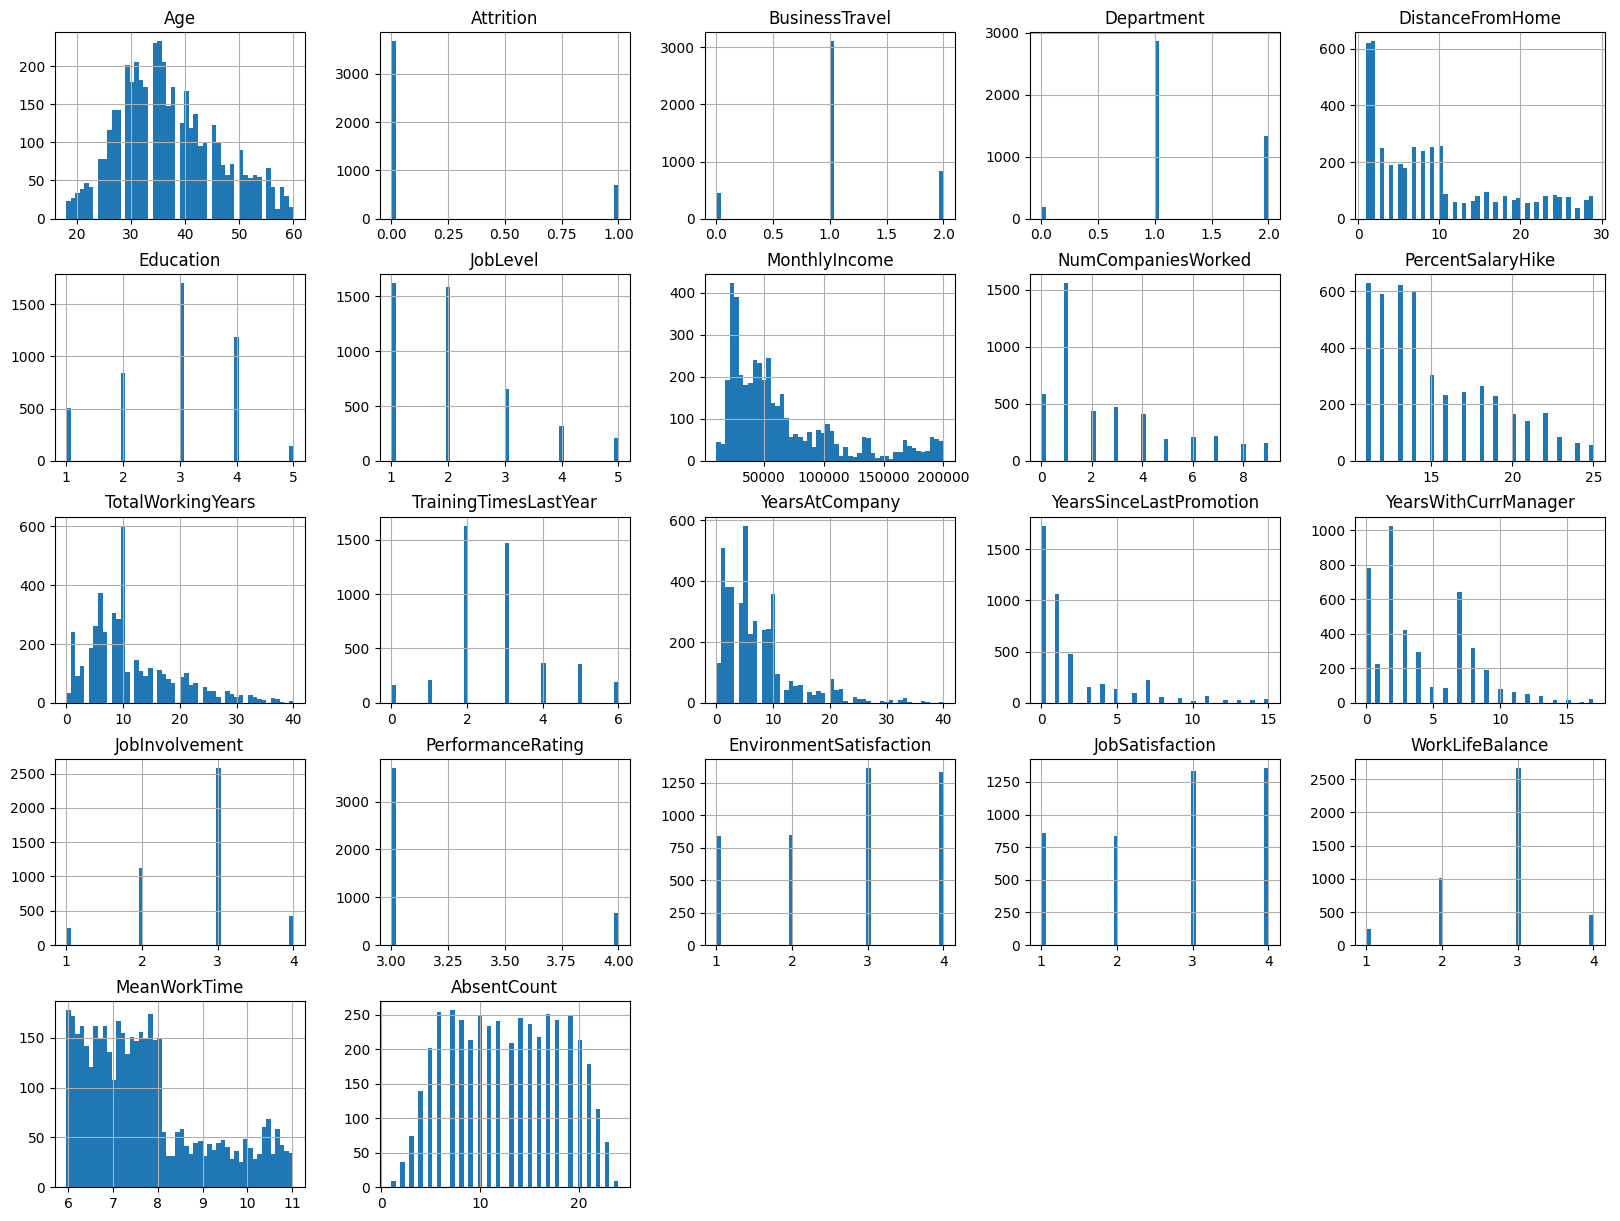

In [18]:
global_dataset.hist(bins=50, figsize=(20,15))
plt.show()

Nous avons donc un taux de turnover de 16.09 %.


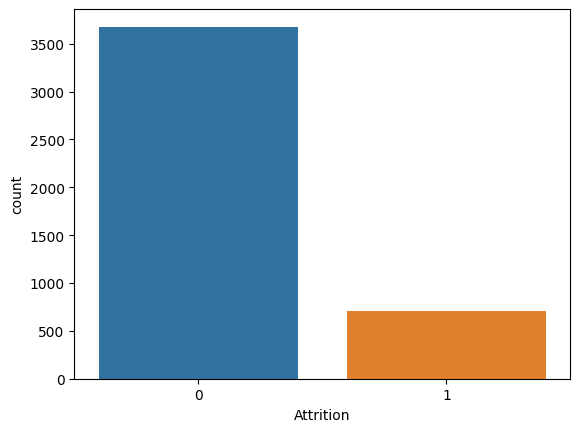

<Axes: xlabel='Attrition', ylabel='Age'>

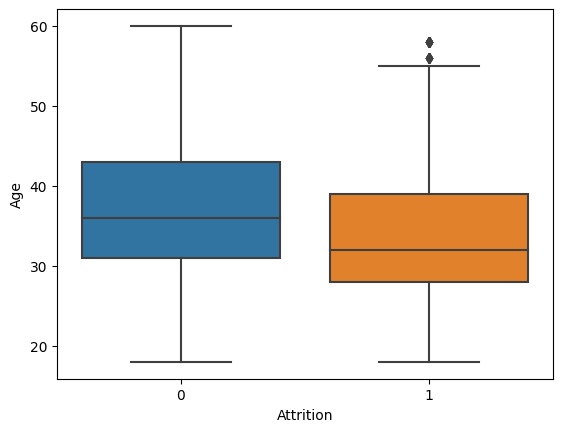

In [19]:
percentage = ((general_data['Attrition'] == 1).sum() / general_data['Attrition'].shape[0]) * 100

print("Nous avons donc un taux de turnover de", round(percentage, 2), "%.")

sns.countplot(x='Attrition', data=general_data)
plt.show()
sns.boxplot(x='Attrition', y='Age', data=general_data)

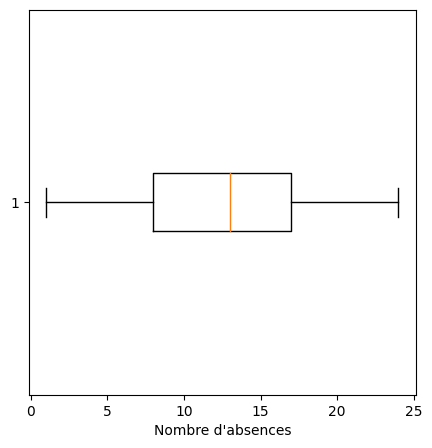

In [20]:
plt.figure(figsize=(5, 5))
plt.boxplot(global_dataset['AbsentCount'], vert=False)
plt.xlabel('Nombre d\'absences')
plt.show()

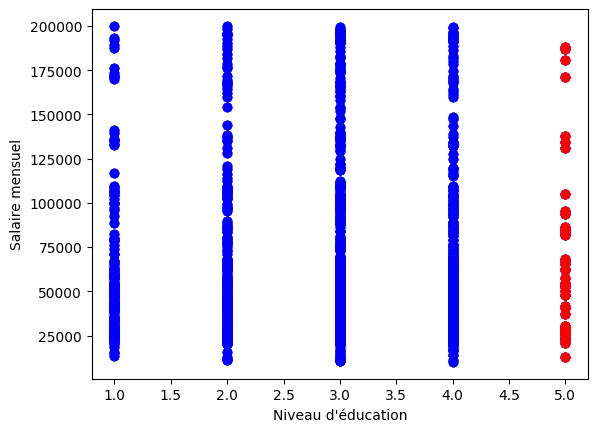

In [21]:
# Tracer le graphe de relation entre le salaire moyen et le niveau d'éducation
plt.scatter(general_data['Education'], general_data['MonthlyIncome'], c='blue')
plt.scatter(general_data[general_data['Education'] == 5]['Education'], general_data[general_data['Education'] == 5]['MonthlyIncome'], c='red')
plt.xlabel('Niveau d\'éducation')
plt.ylabel('Salaire mensuel')
plt.show()


On peut remarquer que les employés ayant un très haut niveau d'éducation ont un salaire relativement bas par rapport aux niveau 2, 3 et 4. C'est donc un point à prendre compte. Certains employés hautement qualifiés pourraient être tentés de quitter l'entreprise pour trouver un poste plus rémunérateur.

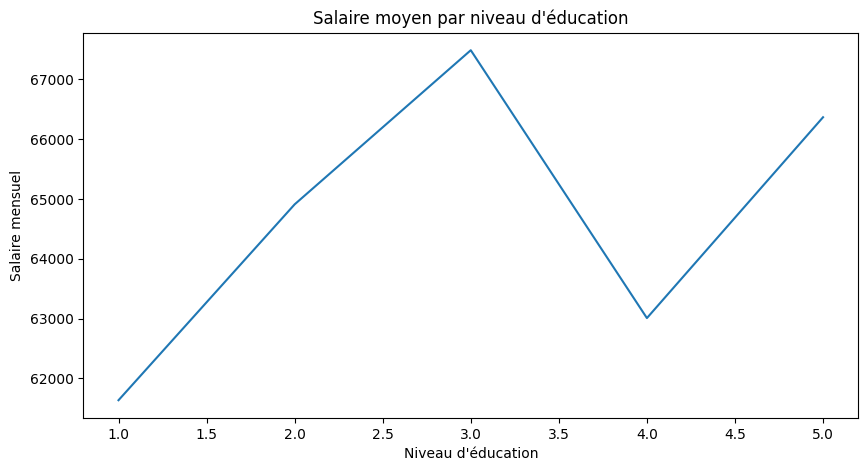

In [22]:
salaire_moyen = general_data.groupby('Education')['MonthlyIncome'].mean()
salaire_moyen.plot(title='Salaire moyen par niveau d\'éducation', figsize=(10, 5))
plt.xlabel('Niveau d\'éducation')
plt.ylabel('Salaire mensuel')
plt.show()

On remarque aussi que la catégorie d'employés ayant un niveau d'éducation de 3, ont le salaire moyen le plus élevé. Il devrait logiquement être plus élevé pour les employés ayant un niveau d'éducation de 4 ou 5.

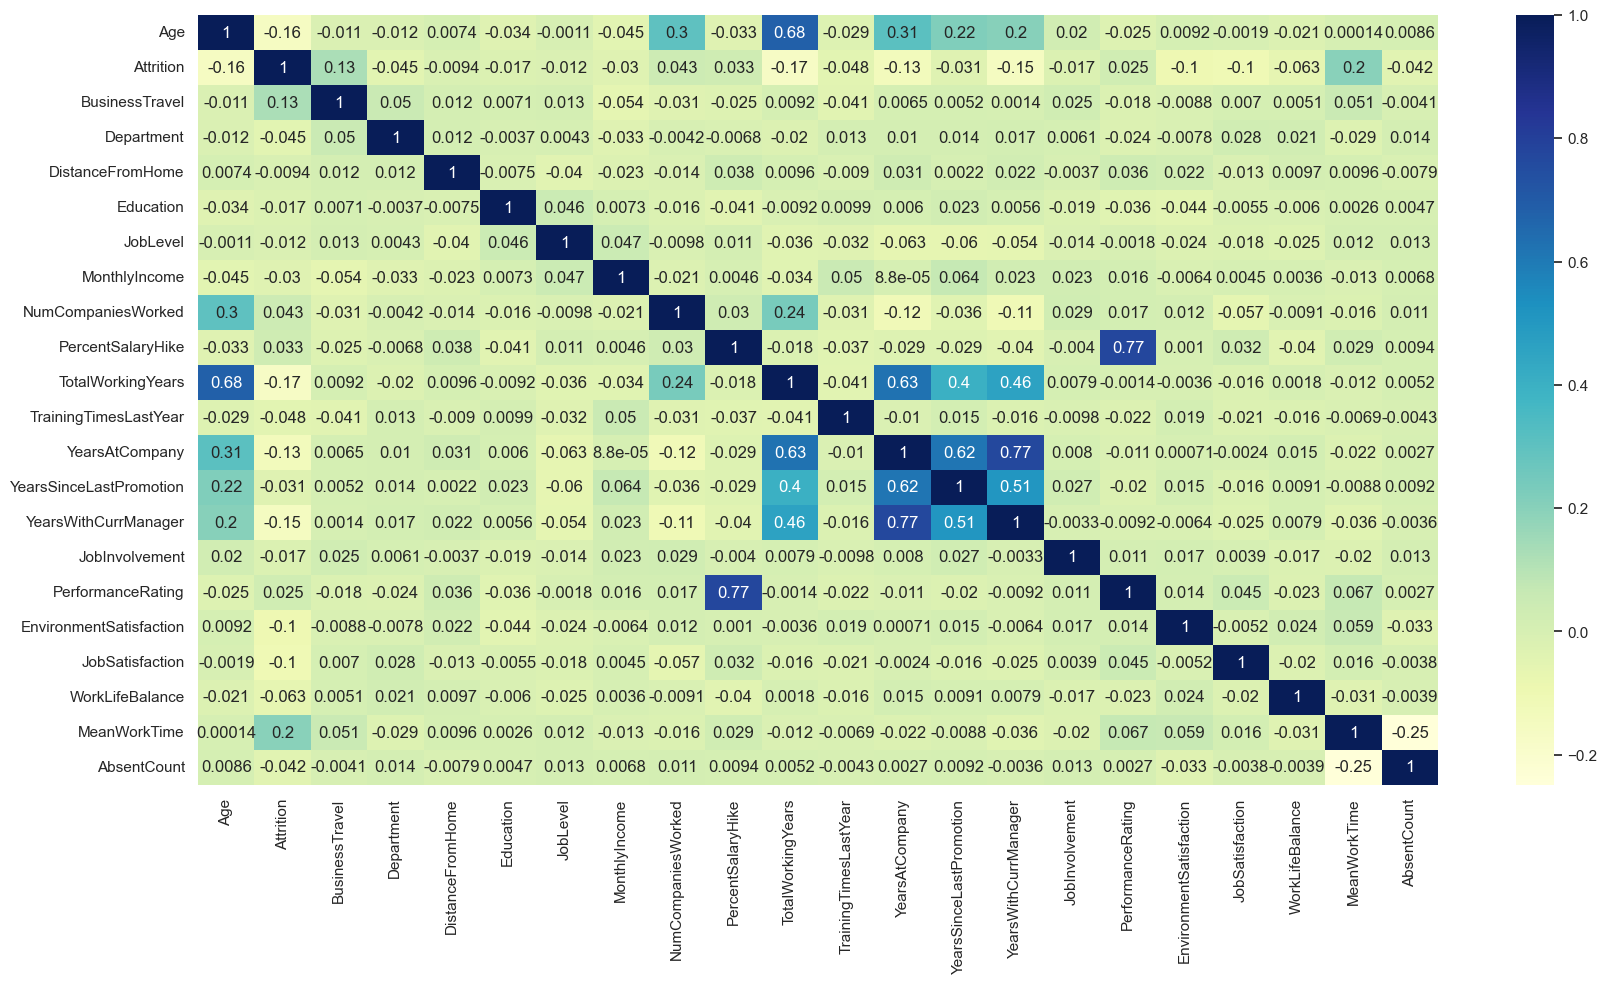

In [23]:
# Visualisation d'une heatmap (carte de chaleur) des paramètres pour voir les corrélations
sns.set(rc={'figure.figsize':(20,10)})
sns.heatmap(global_dataset.corr(), cmap="YlGnBu", annot = True)
plt.show()

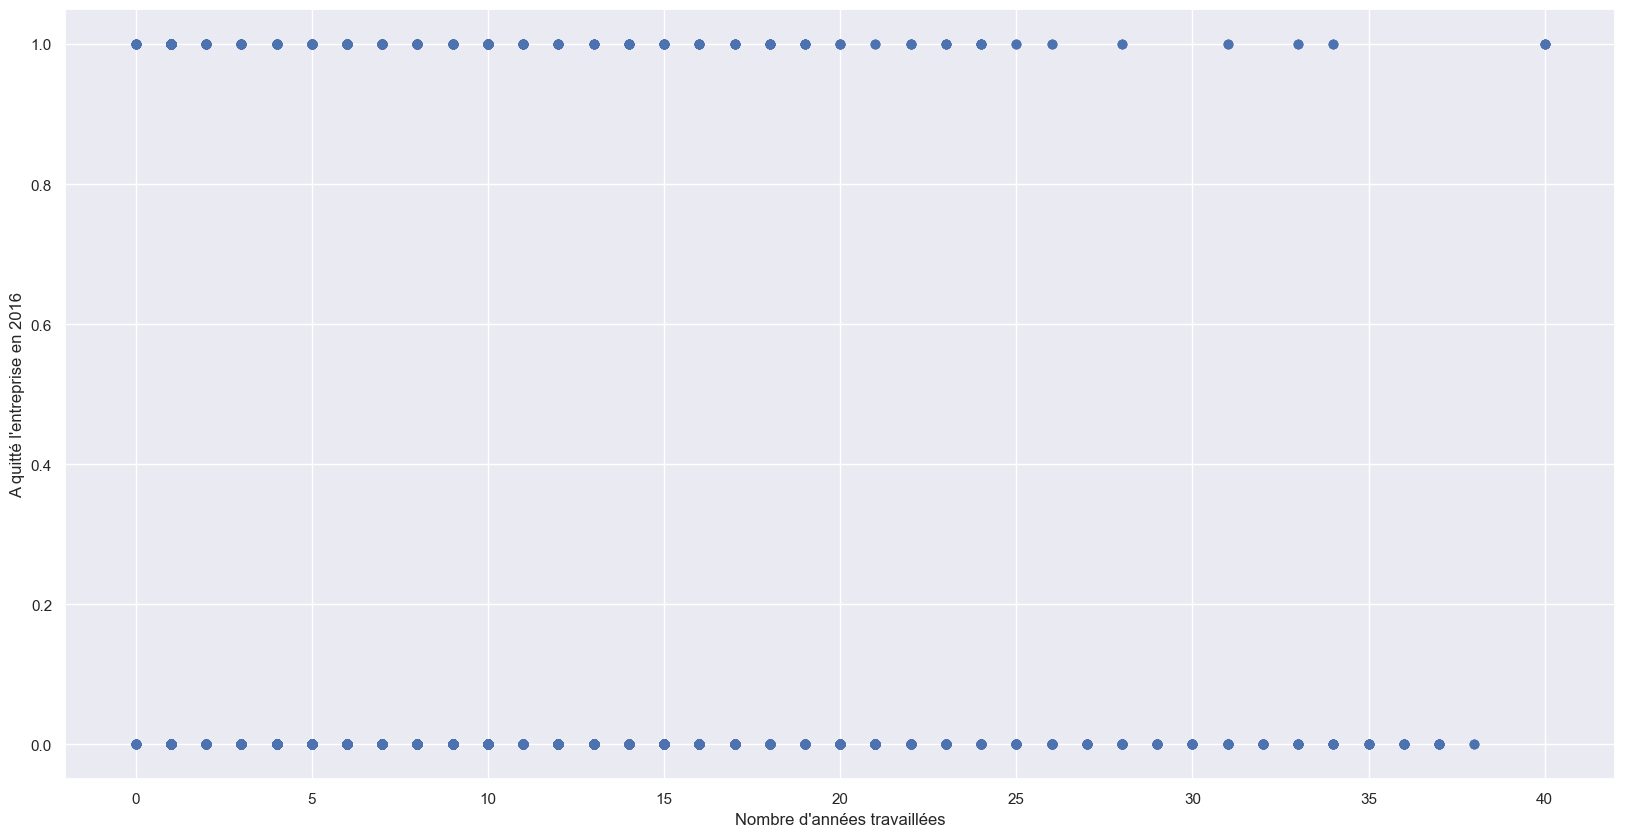

In [24]:
plt.scatter(general_data['TotalWorkingYears'], general_data['Attrition'])
plt.xlabel('Nombre d\'années travaillées')
plt.ylabel('A quitté l\'entreprise en 2016')
plt.show()

Ce sont principalement les jeunes qui quittent l'entreprise.
Les employés avec plus d'experience ont moins tendance à quitter une entreprise puisqu'ils se rapproche de leur fin de carrière.

# Modélisation

On créé un jeu de données d'entrainement et un jeu de données de test avec un ratio 80/20. On va ensuite tester plusieurs modèles différents pour voir lequel donne les meilleurs résultats.

In [25]:
# Scale global_dataset using standard scaler
scaler = StandardScaler()
scaled_global_dataset = scaler.fit_transform(global_dataset)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)

for train_index, test_index in split.split(global_dataset, global_dataset["Attrition"]):
    stratified_train_set = global_dataset.loc[train_index]
    stratified_test_set = global_dataset.loc[test_index]

train_labels = stratified_train_set["Attrition"].copy()
test_labels = stratified_test_set["Attrition"].copy()

In [26]:
for set_ in (stratified_train_set, stratified_test_set):
    set_.drop("Attrition", axis=1, inplace=True)

train_set_prepared = stratified_train_set.copy()

stratified_test_set.head()

,Age,BusinessTravel,Department,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,MeanWorkTime,AbsentCount
3776,34,1,1,2,2,2,65860,9.0,18,9.0,...,2,2,1,3,3,2.0,4.0,2.0,6.11,8
1891,37,1,2,10,4,3,30720,5.0,14,17.0,...,14,11,7,2,3,1.0,3.0,1.0,6.28,22
2848,40,1,1,11,3,2,70050,1.0,20,21.0,...,20,9,9,3,4,4.0,3.0,3.0,6.22,19
674,30,1,2,9,1,4,40890,0.0,18,10.0,...,9,6,7,4,3,1.0,4.0,3.0,6.23,12
2063,28,1,1,6,3,2,23510,1.0,16,6.0,...,6,3,3,3,3,4.0,1.0,3.0,7.16,10


## Test des modèles

Nous allons tester plusieurs modèles différents pour voir lequel donne les meilleurs résultats sur notre jeu de données. Nous allons tester les modèles suivants :
- Decision Tree
- Random Forest
- Logistic Regression

Nous allons suivre le même processus de test pour chacun des modèles afin de pouvoir réellement comparer les résultats. Les étapes de tests sont les suivantes :
- Création du modèle
- Entraînement du modèle
- Score post-entraînement
- Courbe d'apprentissage
- Cross-validation
- Score final
- Calcul du recul, de la précision et du f1-score
- Matrice de confusion finale

### Préparation

In [27]:
def train_rating(model, dataset, labels):
    #Learning curve
    from sklearn.model_selection import learning_curve
    train_sizes, train_scores, test_scores = learning_curve(model, dataset, labels, cv=10, scoring='f1', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

    #Show learning curve
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
    plt.ylabel('F1 score')
    plt.xlabel('Training set size')
    plt.title('Learning curve')
    plt.legend(loc='best')
    plt.show()

In [28]:
def model_rating(model, dataset, labels):
    cf_matrix = confusion_matrix(labels, model.predict(dataset))

    # Calcul du recall
    recall = cf_matrix[1][1] / (cf_matrix[1][1] + cf_matrix[0][1])
    print("Recul :", round(recall, 2)*100, "%")

    # Calcul de la précision
    precision = cf_matrix[1][1] / (cf_matrix[1][1] + cf_matrix[1][0])
    print("Precision :", round(precision, 2)*100, "%")

    # Calcul du F1 score
    f1_score = 2 * (precision * recall) / (precision + recall)
    print("F-score :", round(f1_score, 2)*100, "%")

    # Confusion matrix heatmap
    sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.show()

### Modèle 1 : Arbre de décision

In [29]:
tree_reg = DecisionTreeClassifier(random_state=random_state).fit(train_set_prepared, train_labels)
print("Score du modèle Arbre de décision :", round(tree_reg.score(train_set_prepared, train_labels), 3) * 100, "%")

Score du modèle Arbre de décision : 100.0 %


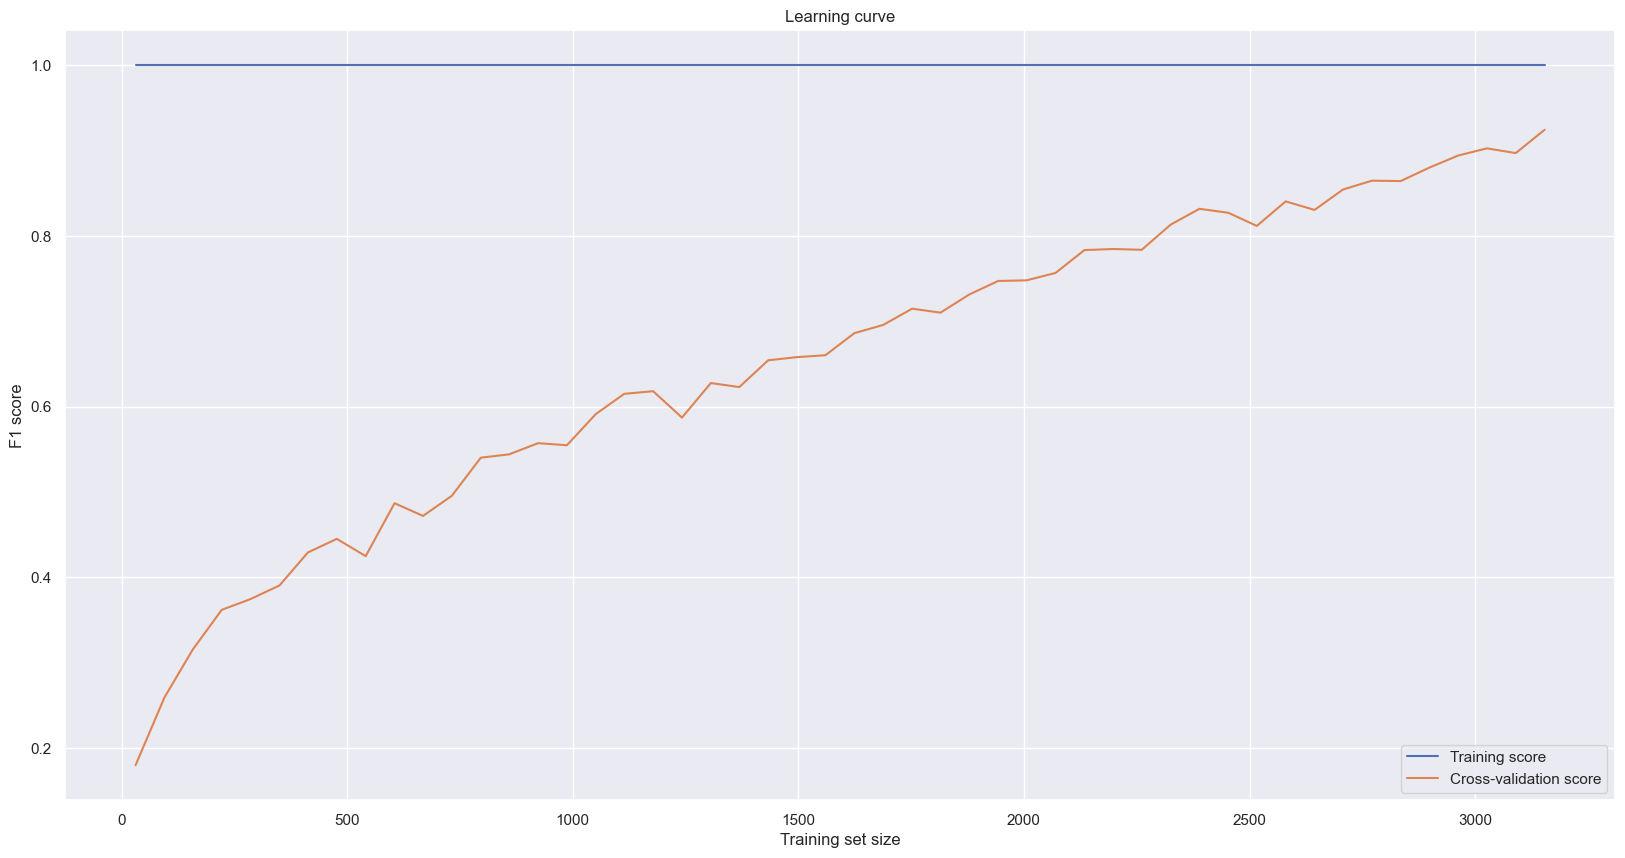

In [30]:
train_rating(tree_reg, train_set_prepared, train_labels)

In [31]:
cross_val_score(tree_reg, train_set_prepared, train_labels, cv=10, scoring="f1")

array([0.92035398, 0.93913043, 0.92982456, 0.86238532, 0.89285714,
       0.94545455, 0.93220339, 0.94444444, 0.92982456, 0.9380531 ])

In [32]:
tree_reg.predict(stratified_test_set)

array([0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [33]:
print("Score du modèle Arbre de décision (Après cross-validation) :", round(tree_reg.score(stratified_test_set, test_labels), 3) * 100, "%")

Score du modèle Arbre de décision (Après cross-validation) : 98.2 %


Recul : 92.0 %
Precision : 97.0 %
F-score : 94.0 %


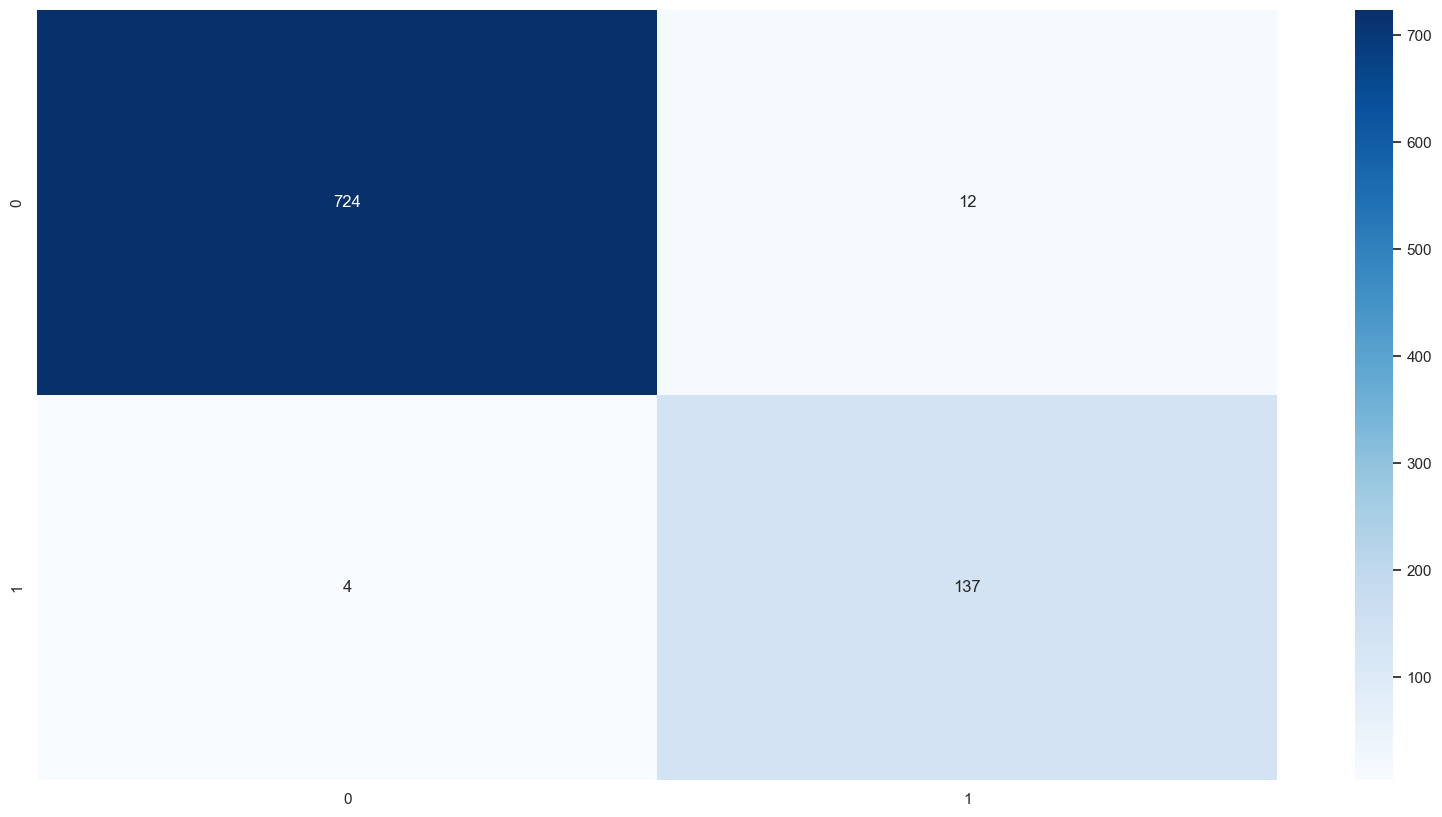

In [34]:
model_rating(tree_reg, stratified_test_set, test_labels)

### Modèle 2 : Random Forest

In [35]:
forest_reg = RandomForestClassifier(n_estimators=10, random_state=random_state).fit(train_set_prepared, train_labels)
print("Score du modèle Random Forest :", round(forest_reg.score(train_set_prepared, train_labels), 3) * 100, "%")

Score du modèle Random Forest : 99.7 %


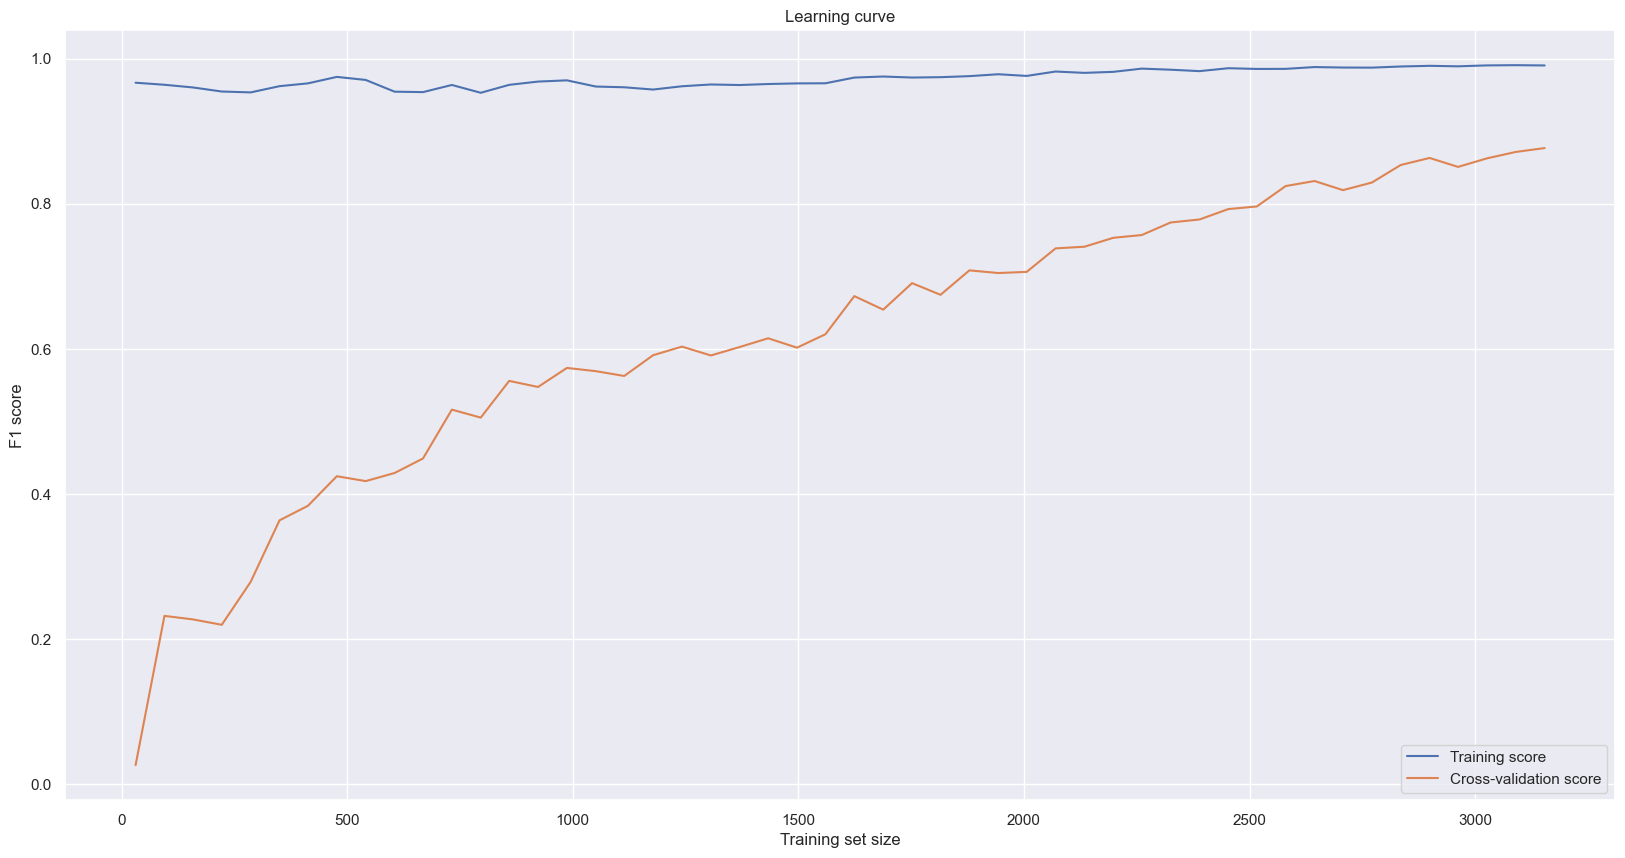

In [36]:
train_rating(forest_reg, train_set_prepared, train_labels)

In [37]:
cross_val_score(forest_reg, train_set_prepared, train_labels, cv=10, scoring="f1")

array([0.93333333, 0.91588785, 0.88235294, 0.79166667, 0.87378641,
       0.8952381 , 0.89320388, 0.89108911, 0.85714286, 0.84848485])

In [38]:
forest_reg.predict(stratified_test_set)

array([0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [39]:
print("Score du modèle Random Forest (Après cross-validation) :", round(forest_reg.score(stratified_test_set, test_labels), 3) * 100, "%")

Score du modèle Random Forest (Après cross-validation) : 96.8 %


Recul : 100.0 %
Precision : 80.0 %
F-score : 89.0 %


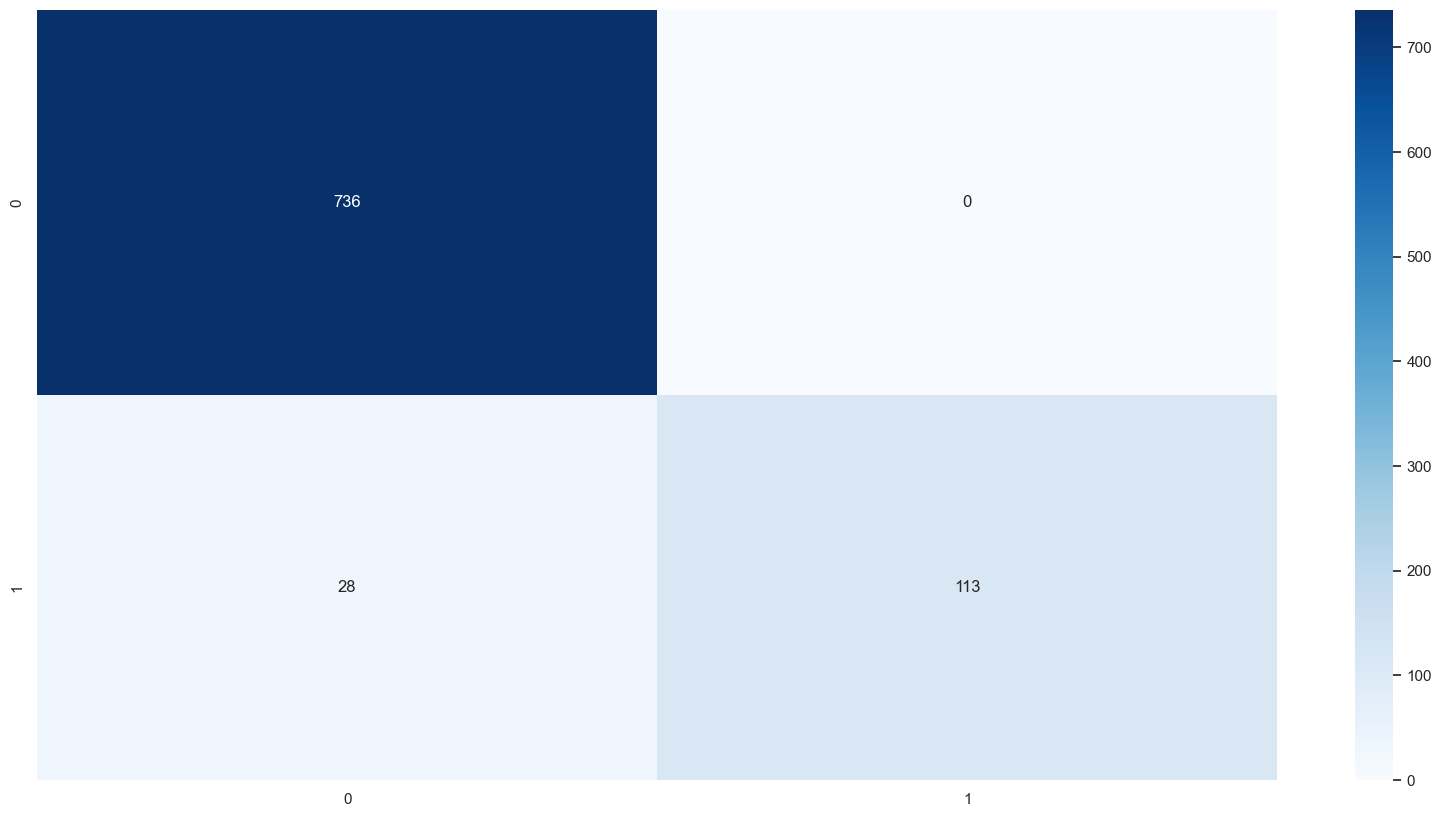

In [40]:
model_rating(forest_reg, stratified_test_set, test_labels)

### Modèle 3 : Régression logistique

In [41]:
logistic_reg = LogisticRegression(random_state=random_state).fit(train_set_prepared, train_labels)
print("Score du modèle de Régression Logistique :", round(logistic_reg.score(train_set_prepared, train_labels), 3) * 100, "%")

Score du modèle de Régression Logistique : 83.89999999999999 %


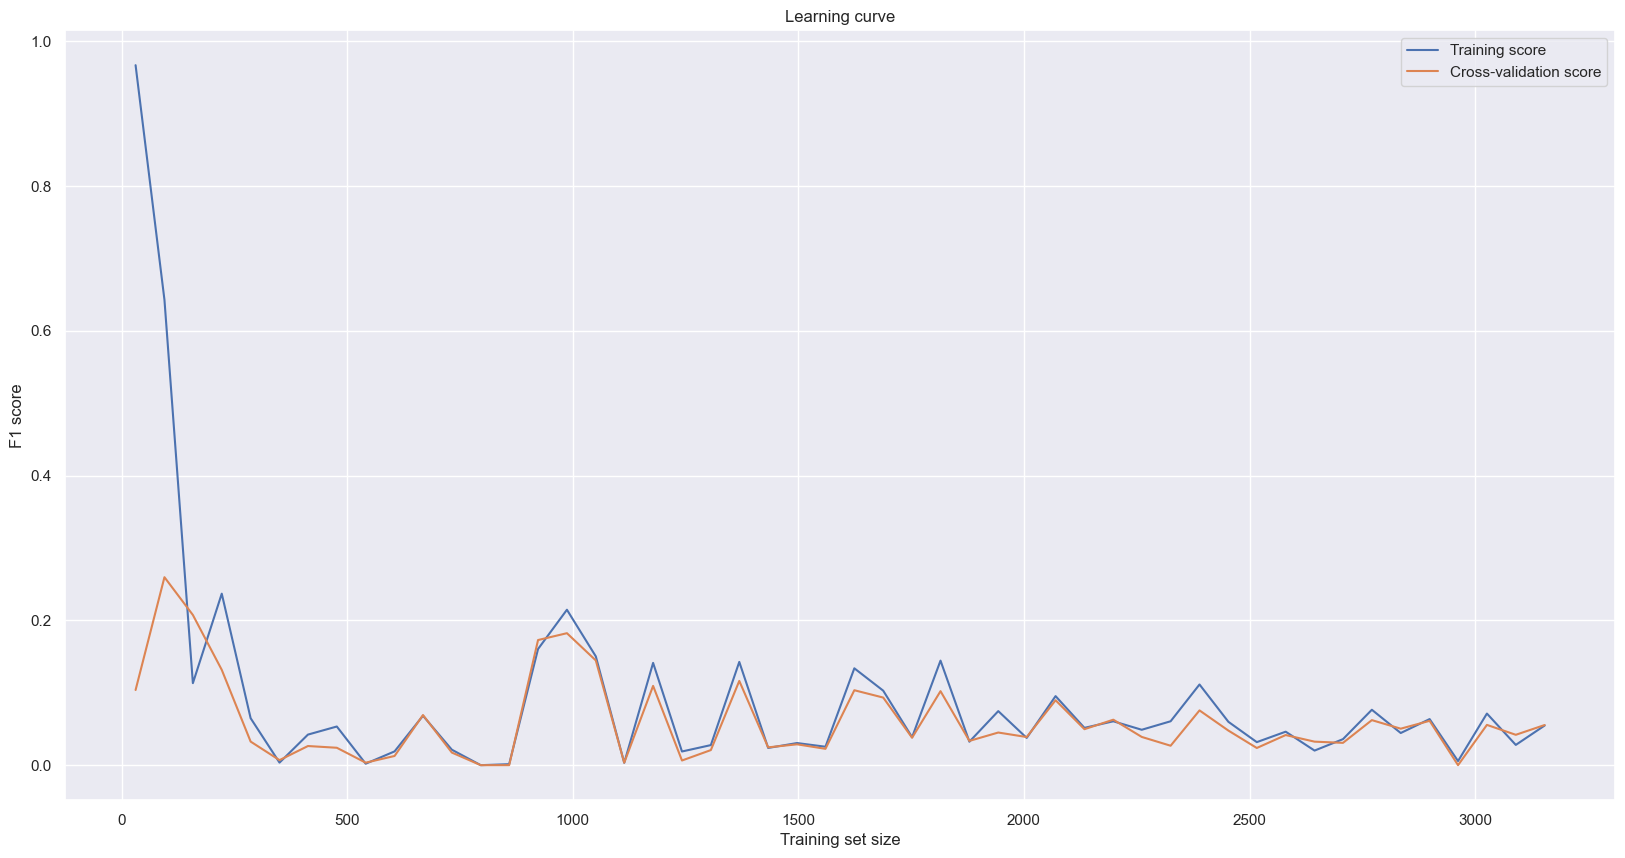

In [42]:
train_rating(logistic_reg, train_set_prepared, train_labels)

In [43]:
cross_val_score(logistic_reg, train_set_prepared, train_labels, cv=10, scoring="f1")

c:\Users\thiba\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\thiba\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

array([0.        , 0.15151515, 0.        , 0.17142857, 0.        ,
       0.        , 0.18461538, 0.        , 0.03508772, 0.        ])

In [44]:
logistic_reg.predict(stratified_test_set)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [45]:
print("Score du modèle de Régression Logistique (Après cross-validation) :", round(logistic_reg.score(stratified_test_set, test_labels), 3) * 100, "%")

Score du modèle de Régression Logistique (Après cross-validation) : 83.89999999999999 %


Recul : nan %
Precision : 0.0 %
F-score : nan %


C:\Users\thiba\AppData\Local\Temp\ipykernel_5728\168213668.py:5: RuntimeWarning: invalid value encountered in scalar divide
  recall = cf_matrix[1][1] / (cf_matrix[1][1] + cf_matrix[0][1])


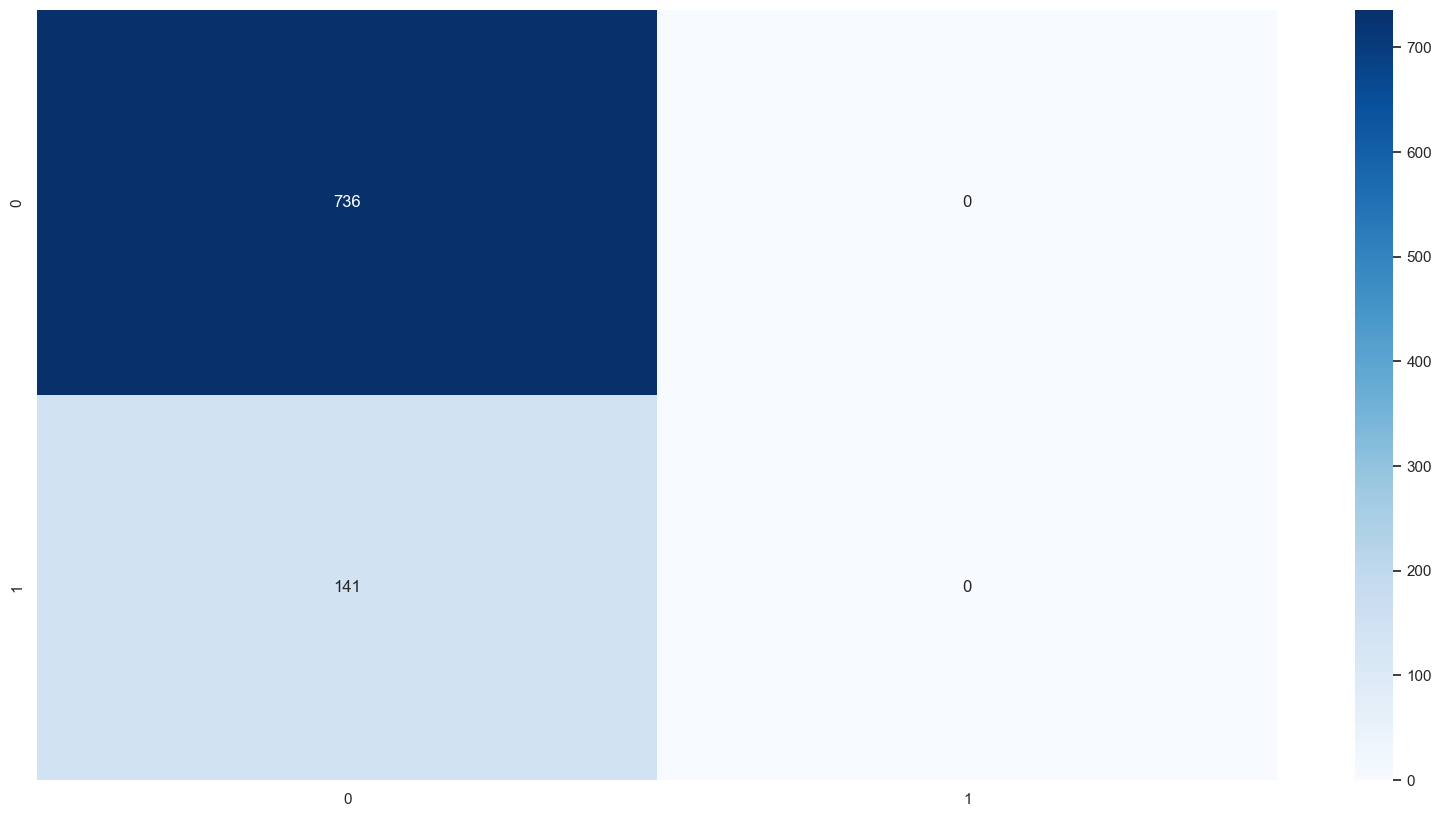

In [46]:
model_rating(logistic_reg, stratified_test_set, test_labels)

## Conclusion des tests

Les tests montrent de bons résultats pour les modèles *Decision Tree* et *Random Forest* qui ont de très bons scores et une bonne courbe d'apprentissage.

Le modèle *Logistic Regression* n'est **pas du tout adapté**, comme la courbe d'apprentissage le montre, il ne s'adapte pas à notre jeu de données et n'arrive pas à apprendre, il ne prédit que des 0. Il est donc à **exclure** de notre étude.

Nous avons décidé de partir sur le modèle **Random Forest** même si le score est légèrement inférieur au modèle *Decision Tree* car il est plus robuste et plus précis après optimisation. Nous le choisissons également car la **précision** est plus élevé que pour le modèle *Decision Tree*, ce qui signifie qu'il est plus capable d'identifier les employés qui vont quitter l'entreprise que de le Decision Tree.

## Optimisation du modèle

Pour obtenir le meilleur modèle possible, nous allons optimiser les hyper-paramètres du modèle *Random Forest* afin de trouver les meilleurs paramètres pour notre jeu de données. Nous allons donc tester plusieurs combinaisons d'hyper-paramètres pour trouver les meilleurs résultats. On va tester les hyper-paramètres suivants :
- n-estimators
- max-feature  
- max-depth
- min-sample-split
- min-sample-leaf
- bootstrap

On va essayer d'avoir une piste en regardant le f1-score après une variation du nombre d'estimateurs.

In [47]:
f1_scores = []
for i in tqdm.tqdm(range(1, 100)):
    forest_reg = RandomForestClassifier(n_estimators=i, random_state=random_state).fit(train_set_prepared, train_labels)
    f1_scores.append(f1_score(test_labels, forest_reg.predict(stratified_test_set)))

100%|██████████| 99/99 [00:22<00:00,  4.46it/s]


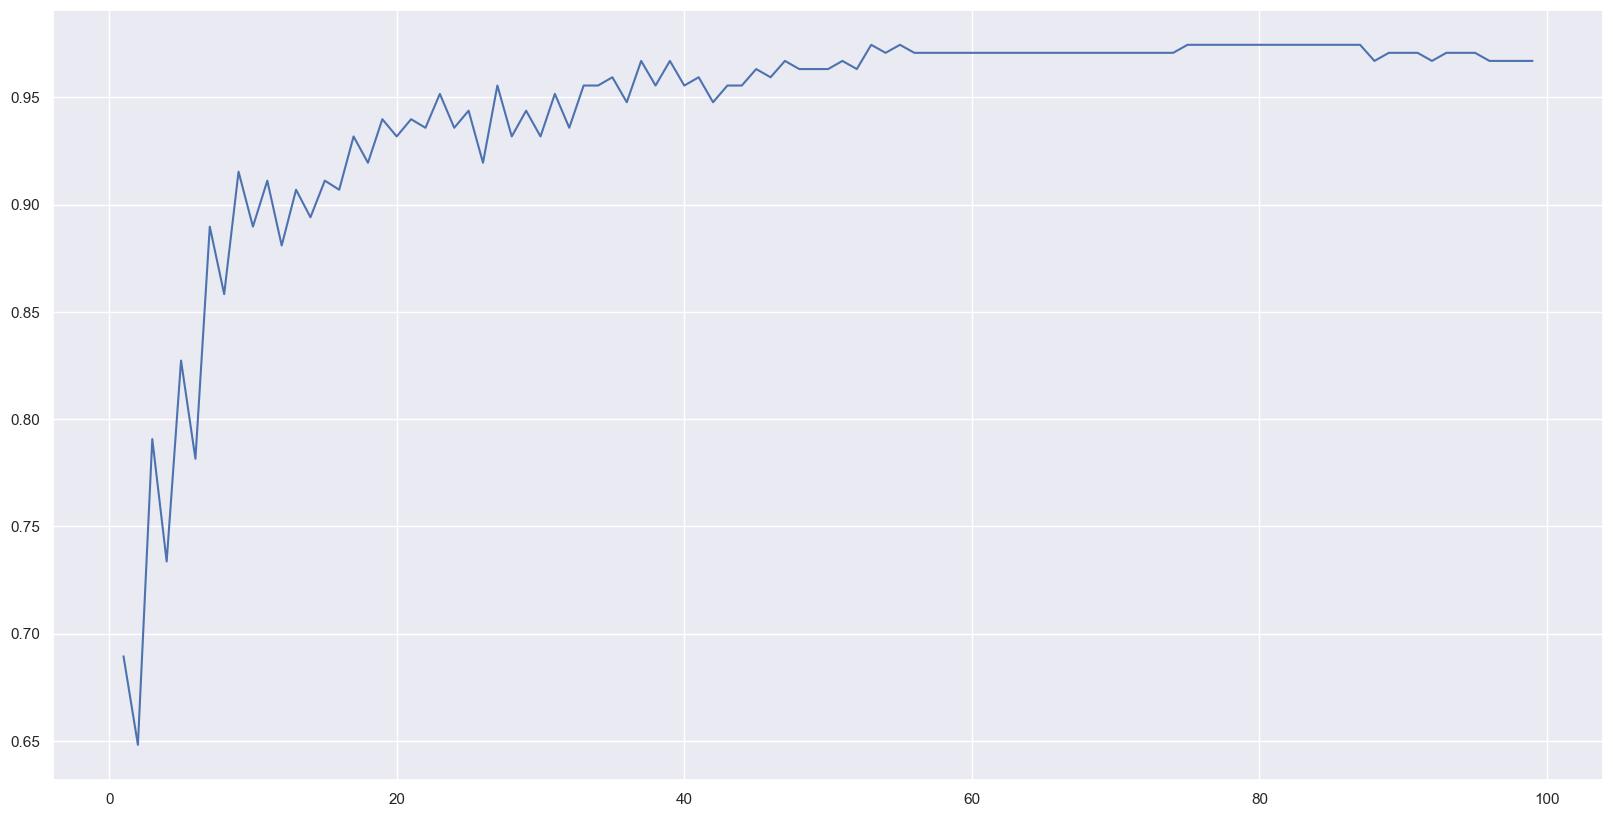

In [48]:
plt.plot(range(1, 100), f1_scores)
plt.show()

On remarque que le paramètre optimal pour *n-estimators* est d'environ 70. On va vérifier cela avec une **RandomSearchCV**.

In [49]:
param_distribs = {
        'n_estimators': randint(low=1, high=150),
        'max_features': randint(low=1, high=10),
        'max_depth': randint(low=1, high=50),
        'min_samples_split': randint(low=1, high=10),
        'min_samples_leaf': randint(low=1, high=10),
        'bootstrap': [True, False]
    }

forest_reg = RandomForestClassifier(n_estimators=70, random_state=random_state)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=100, cv=5, scoring='f1', random_state=random_state, n_jobs=-1).fit(stratified_train_set, train_labels)

In [50]:
rnd_search.best_params_

{'bootstrap': False,
 'max_depth': 22,
 'max_features': 6,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 70}

On va maintenant tester avec les paramètres trouvés précédemment pour voir si on obtient de meilleurs résultats.

In [51]:
forest_reg = RandomForestClassifier(bootstrap=False, max_depth=27, max_features=3, min_samples_leaf=1, min_samples_split=3, n_estimators=101, random_state=random_state).fit(train_set_prepared, train_labels)
print("Score du modèle Random Forest optimisé :", round(forest_reg.score(train_set_prepared, train_labels), 5) * 100, "%")

Score du modèle Random Forest optimisé : 100.0 %


In [52]:
cross_val_score(forest_reg, train_set_prepared, train_labels, cv=10, scoring="f1")

array([0.97247706, 0.93693694, 0.97297297, 0.94545455, 0.96363636,
       0.96296296, 0.98214286, 0.96296296, 0.95495495, 0.97247706])

In [53]:
print("Score du modèle Random Forest (Après cross-validation) :", round(forest_reg.score(stratified_test_set, test_labels), 3) * 100, "%")

Score du modèle Random Forest (Après cross-validation) : 99.7 %


Recul : 100.0 %
Precision : 98.0 %
F-score : 99.0 %


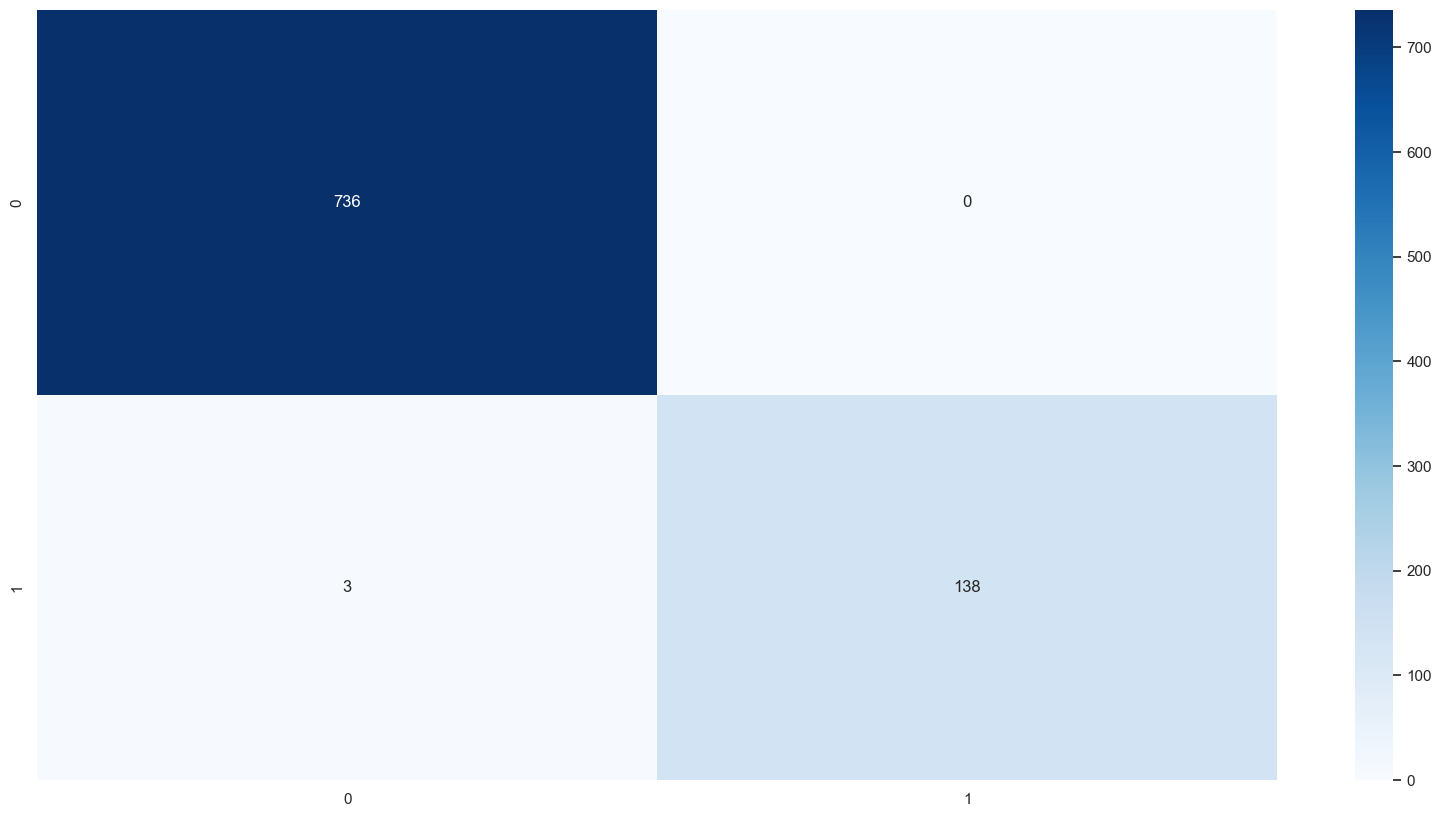

In [54]:
model_rating(forest_reg, stratified_test_set, test_labels)

### Score AUC

In [55]:
probs = forest_reg.predict_proba(stratified_test_set)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(test_labels, probs)
# afficher l'AUC
print('Score AUC:', round(auc, 5)*100, "%")


Score AUC: 99.97200000000001 %


### Courbe ROC

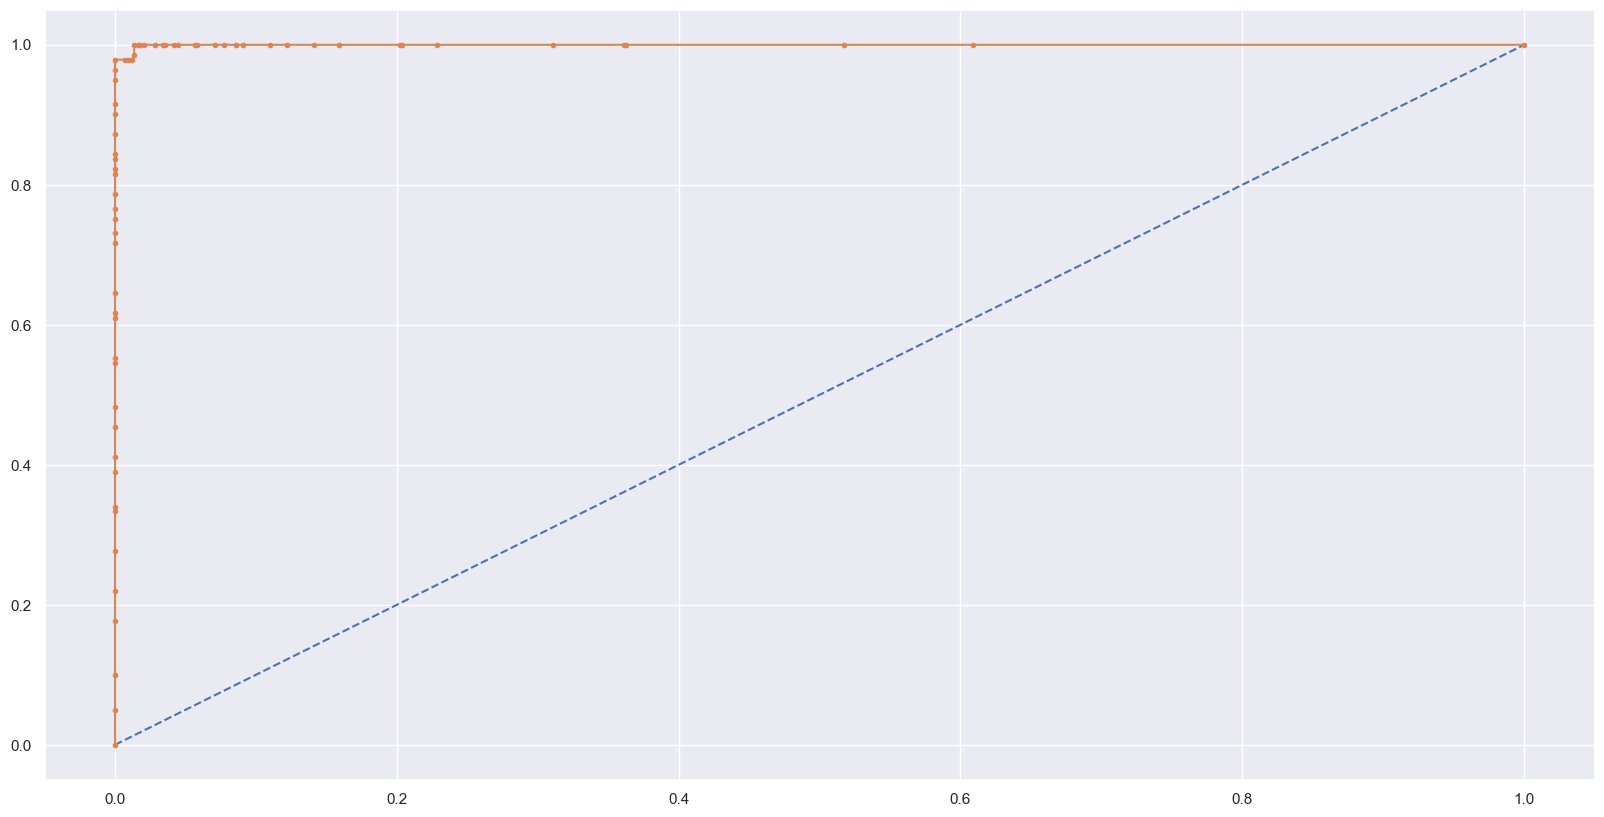

In [56]:
fpr, tpr, thresholds = roc_curve(test_labels, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

## Conclusion de l'optimisation

Nous avons obtenu de meilleurs résultats avec les paramètres optimisés. Le score est passé de **97%** à **99.7%** et le recul est arrivée très *proche* de 100%. Nous avons donc obtenu un modèle très performant.

## Paramètres influants sur l'attrition

Nous allons maintenant essayer de trouver les paramètres qui influencent le plus l'attrition des employés. Pour cela, nous allons utiliser la fonction *feature_importances_* sur notre modèle optimisé.

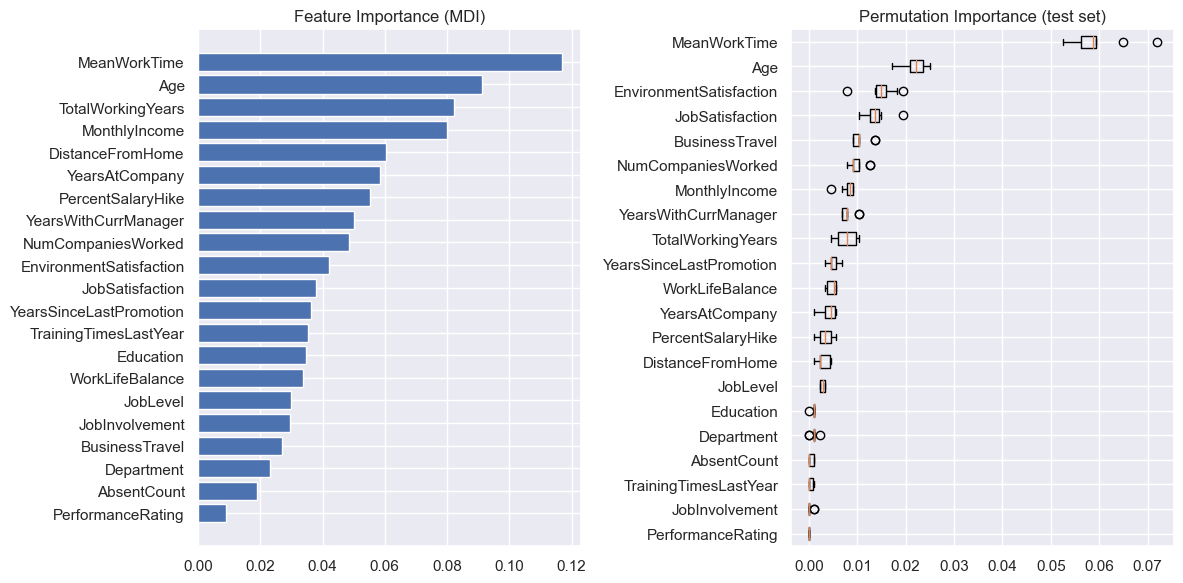

In [57]:
feature_importance = forest_reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(forest_reg.feature_names_in_)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    forest_reg, stratified_test_set, test_labels, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(forest_reg.feature_names_in_)[sorted_idx],
)
plt.title("Permutation Importance (test set)")

fig.tight_layout()
plt.show()

In [58]:
def plot_mdi_values(column, dataset=global_dataset):
    x = column
    y = 'Attrition'
    data = global_dataset.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index() if dataset is global_dataset else dataset.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index()
    sns.set_context('talk')
    graph = sns.catplot(data=data, x=x, y='percent', hue='Attrition', kind='bar', height = 9, aspect = 3, legend_out=True, margin_titles=True)
    graph.set_xticklabels(rotation=90, horizontalalignment='right')
    graph.set_ylabels('Pourcentage')
    graph.set_titles('{col_name}')

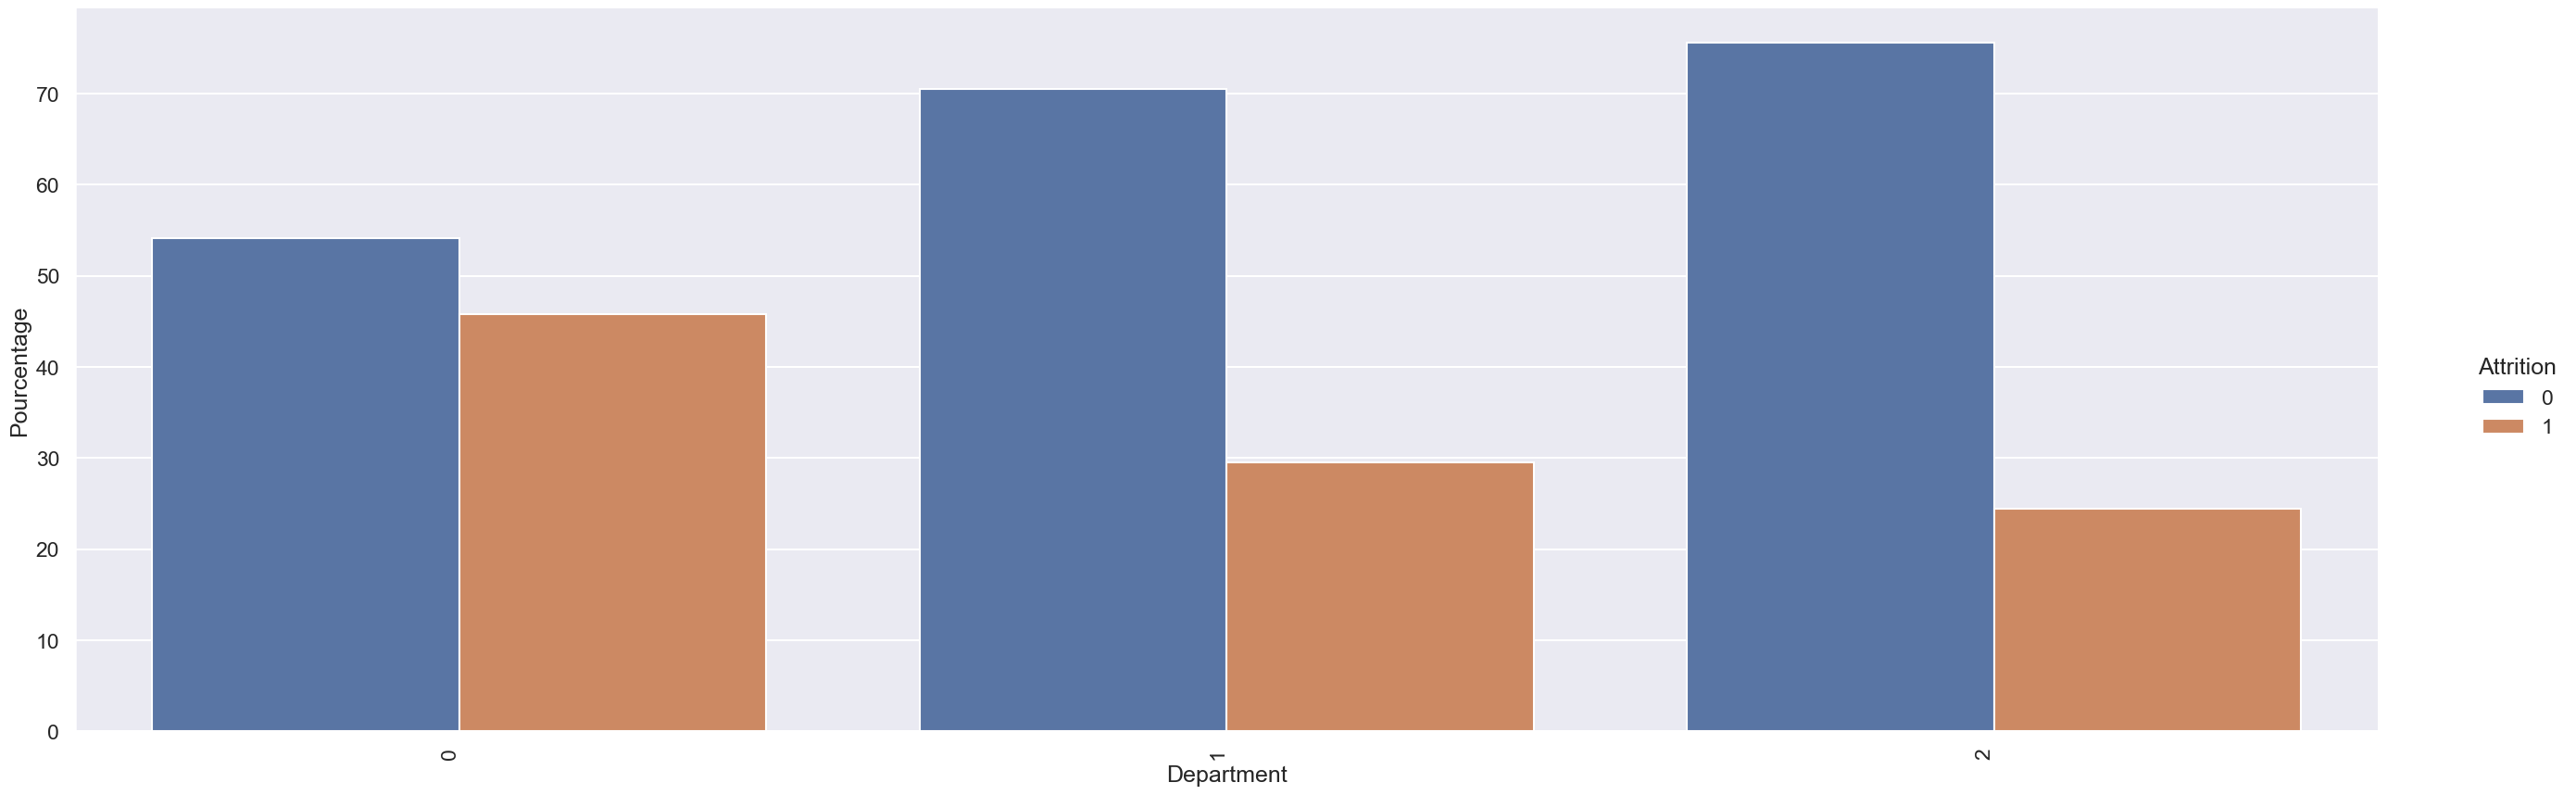

In [59]:
plot_mdi_values('Department', global_dataset[global_dataset['MeanWorkTime'] > 8])

Beaucoup de personnes travaillant **plus** que le temps de **8h** prévu dans le contrat partent de l'entreprise.

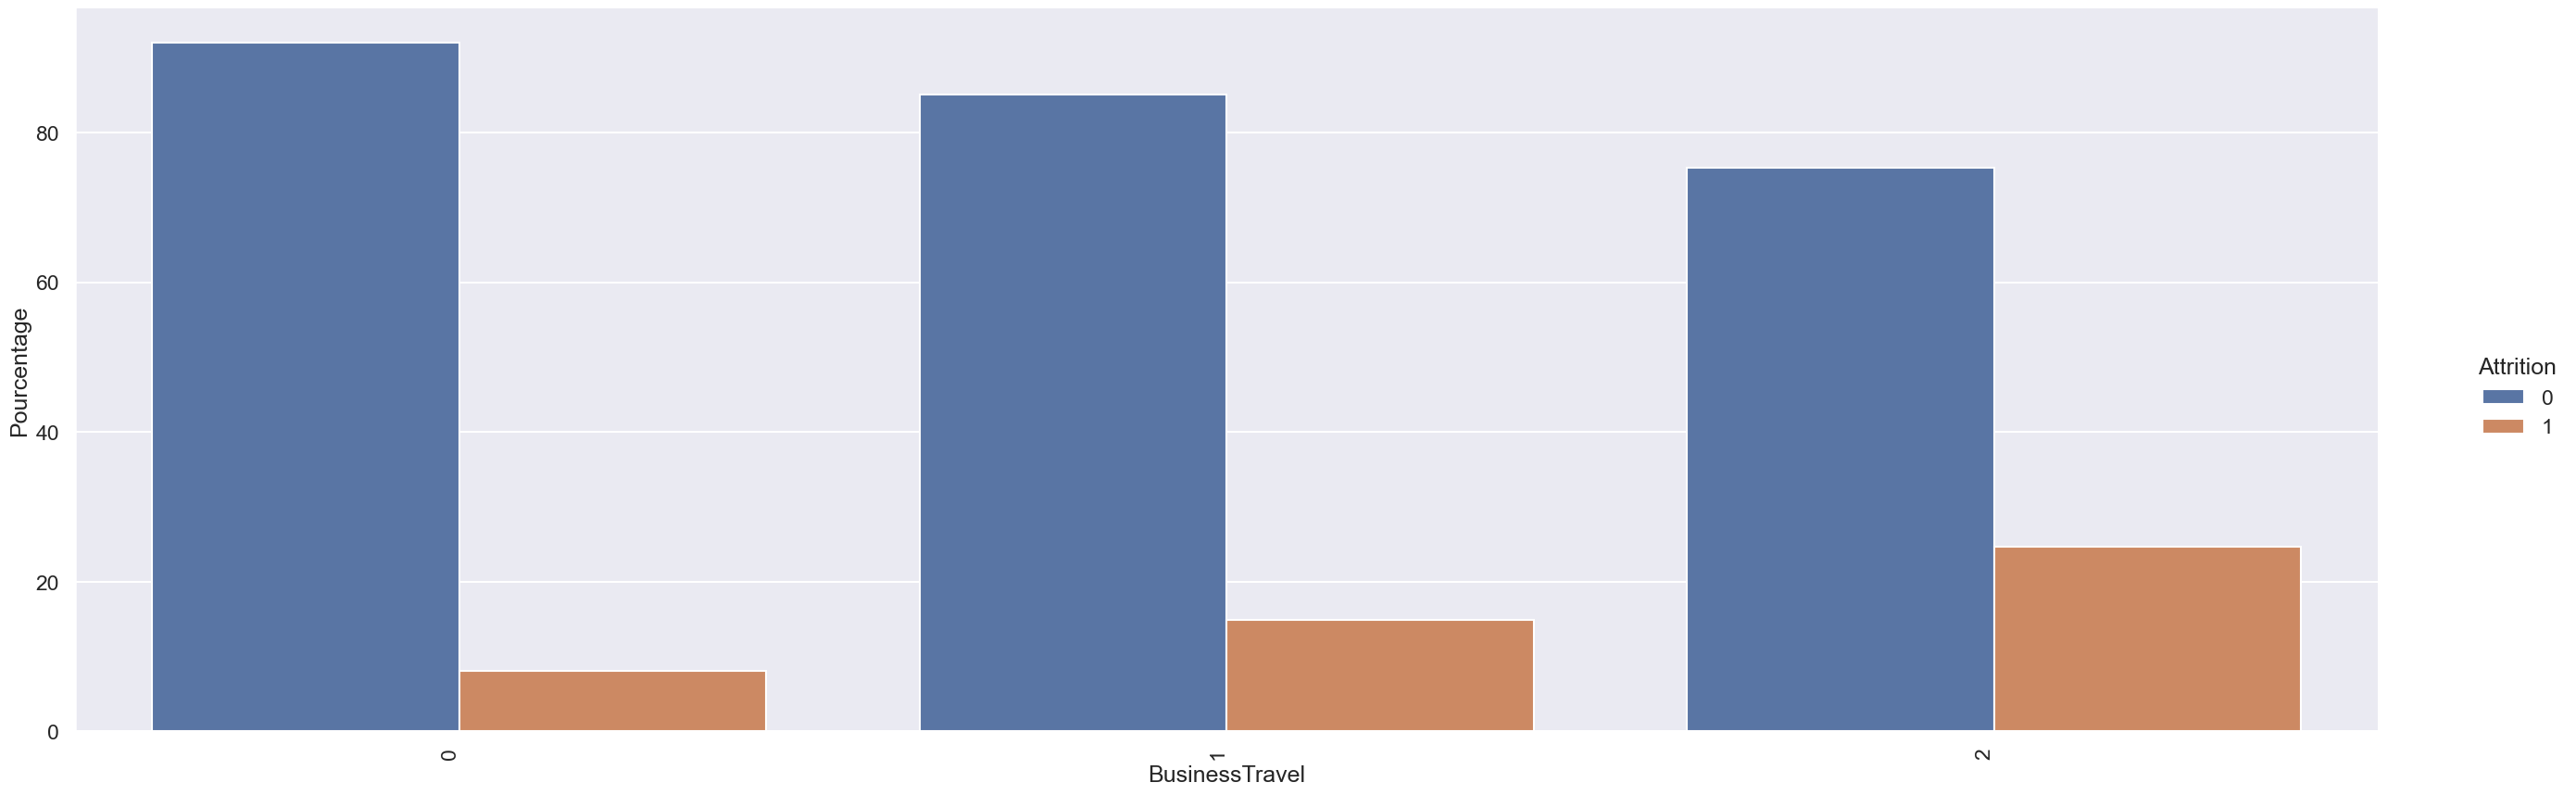

In [60]:
plot_mdi_values('BusinessTravel')

On peut remarquer que **plus** le salarié voyage **plus** il est susceptible de **partir**. 

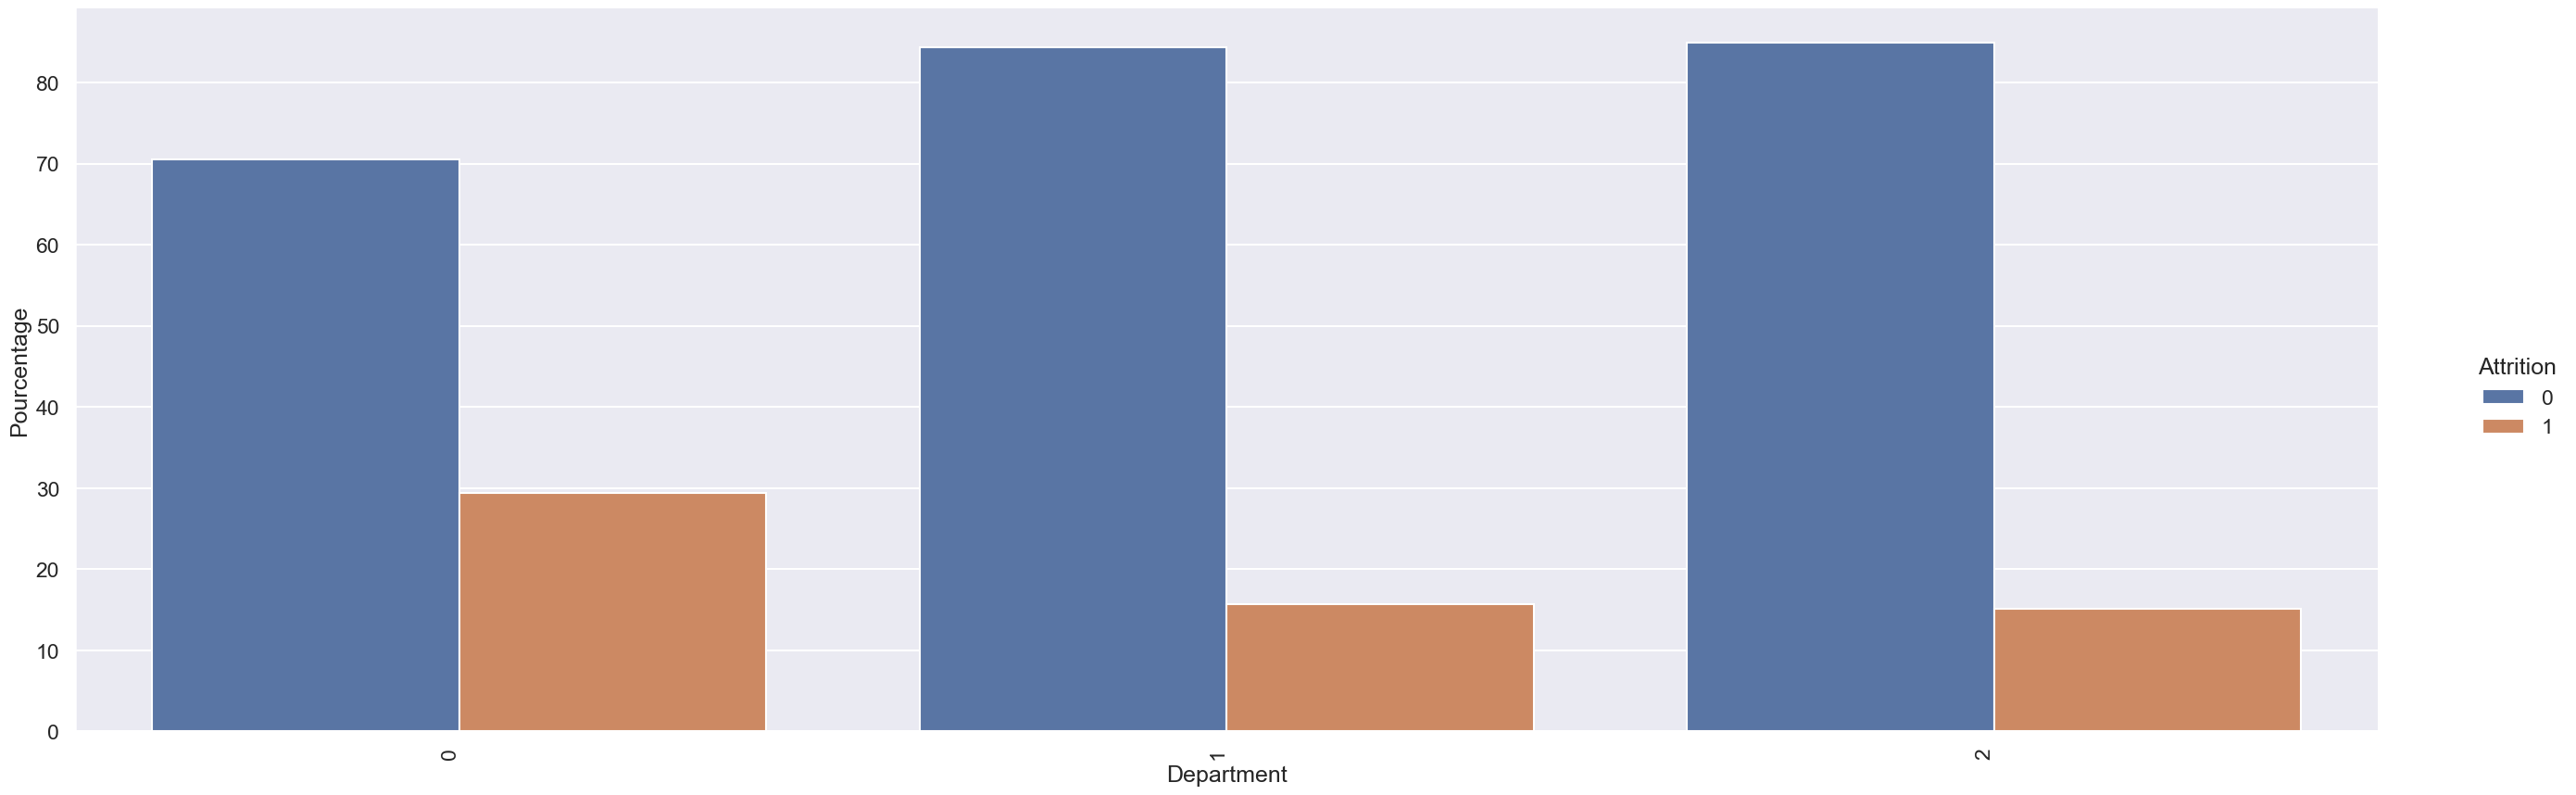

In [61]:
plot_mdi_values('Department')

Beaucoup de personnes du département des **Ressources Humaines** (quasiment **1/3**) ont quitté l'entreprise. Cela peut être dû au fait que les RH sont souvent les premiers à être licenciés lors d'une réorganisation de l'entreprise.

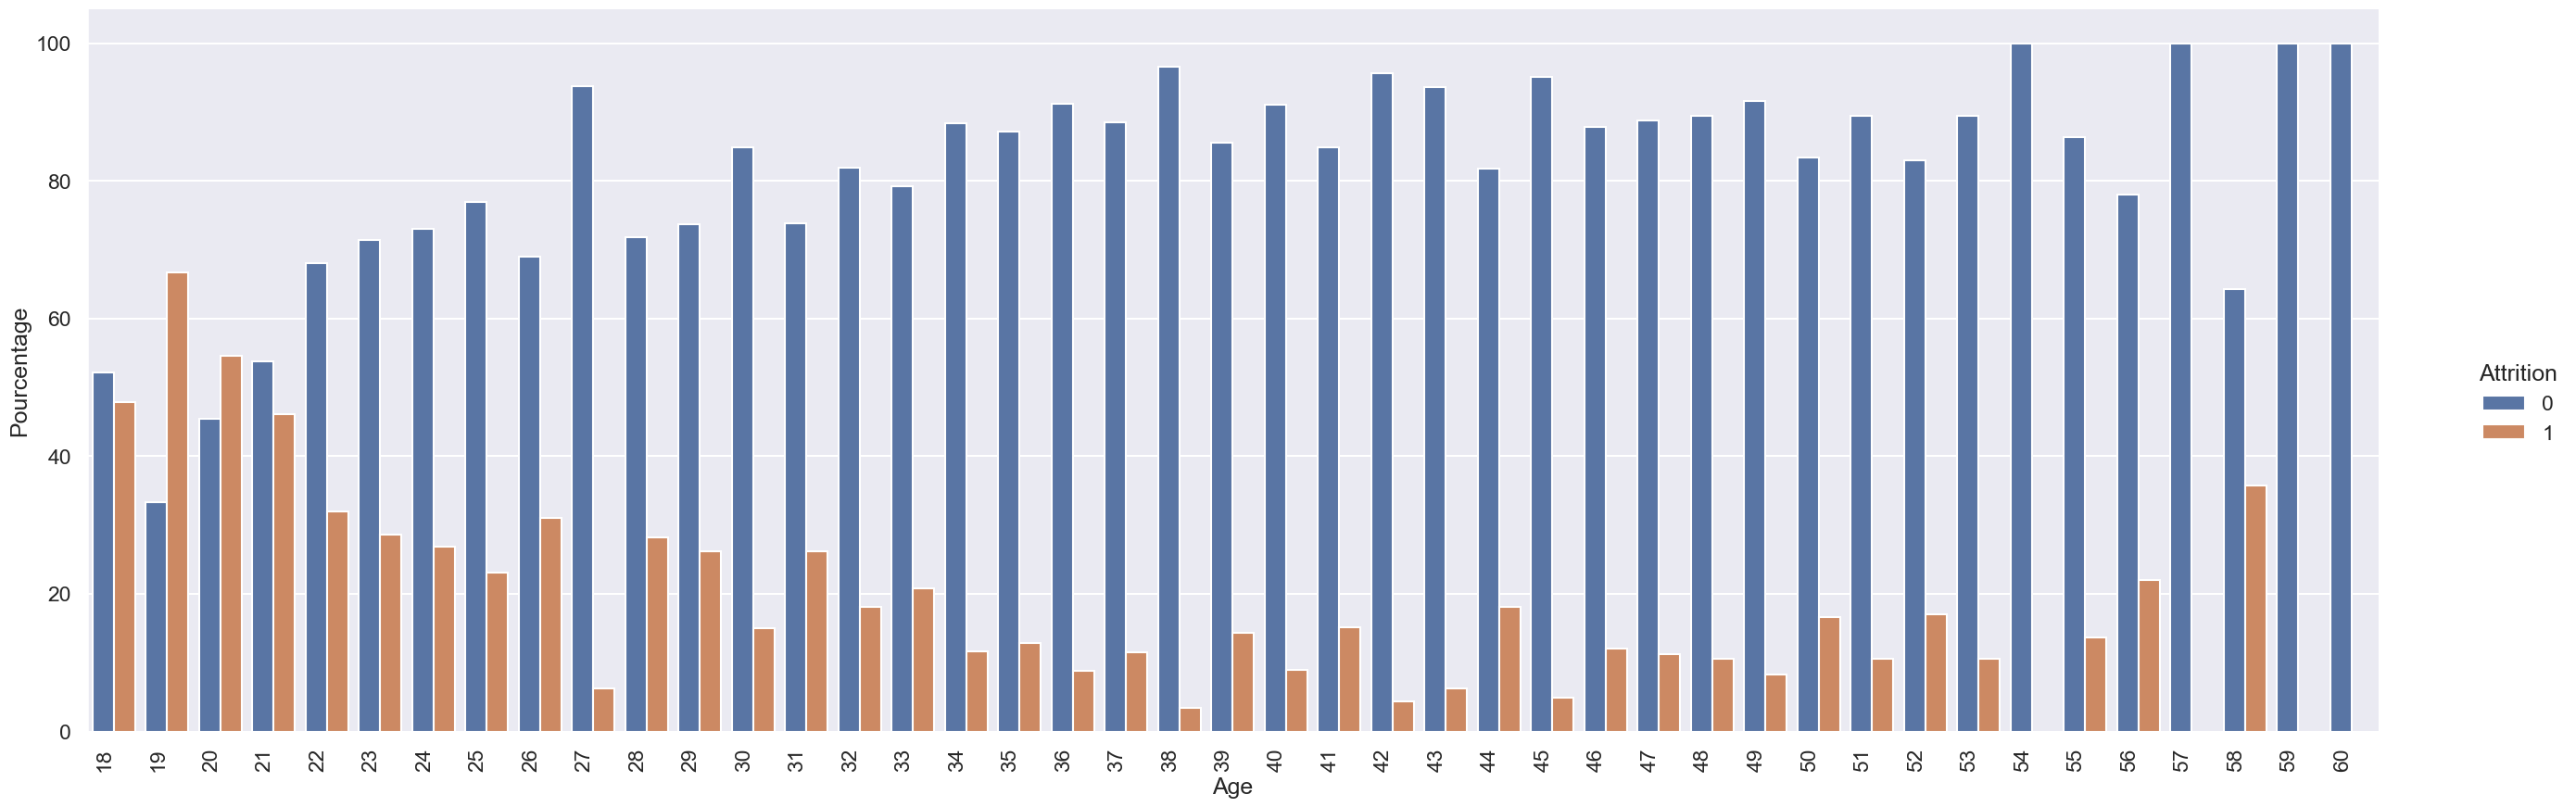

In [62]:
plot_mdi_values('Age')

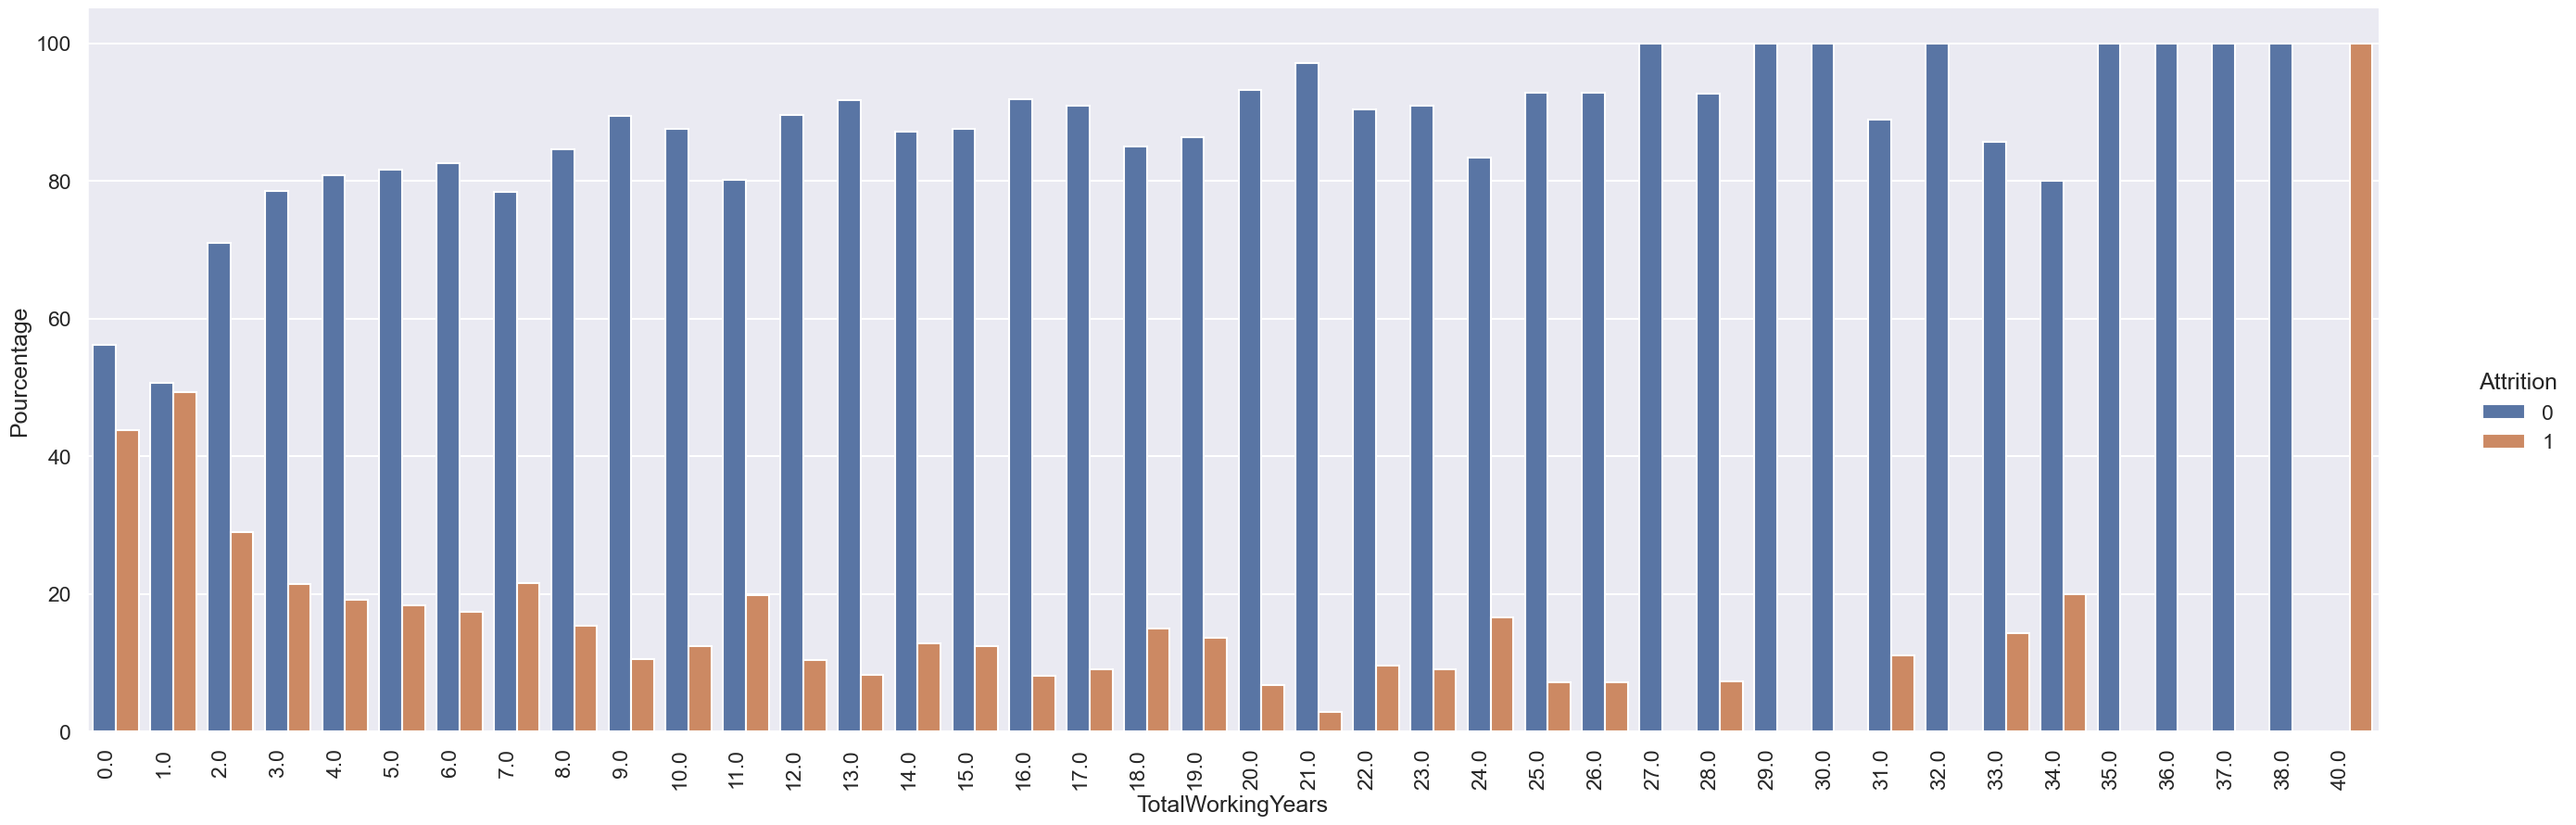

In [63]:
plot_mdi_values('TotalWorkingYears')

Les employés les plus *jeunes* (**18-27** ans) et les employés ayant travaillé très peu sont les plus susceptibles de quitter l'entreprise, il y a quasiment autant de départ que d'arrivé ! Cela peut être dû au fait qu'ils sont plus mobiles et qu'ils ont moins d'obligations familiales.

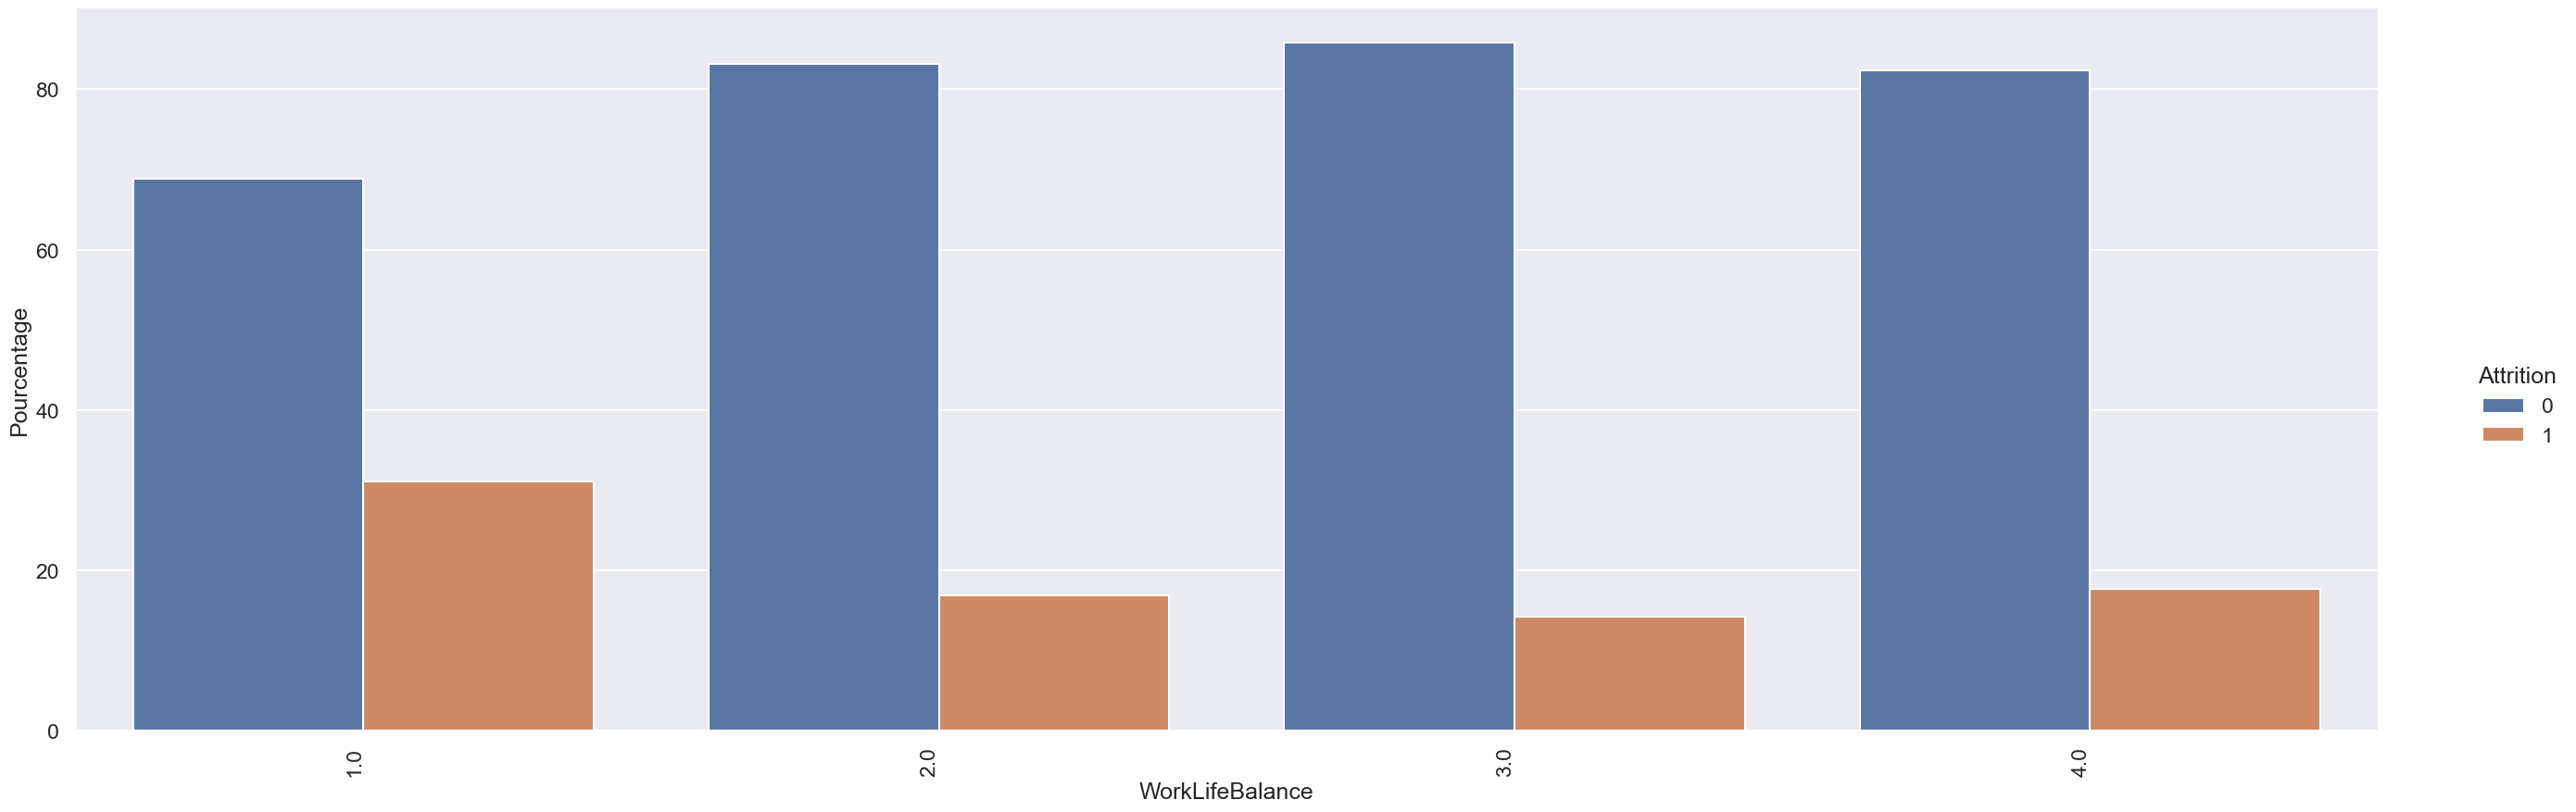

In [64]:
plot_mdi_values('WorkLifeBalance')

Les personnes n'arrivant pas à **combiner** *travail* et *vie personnelle* sont plus susceptibles de quitter l'entreprise.

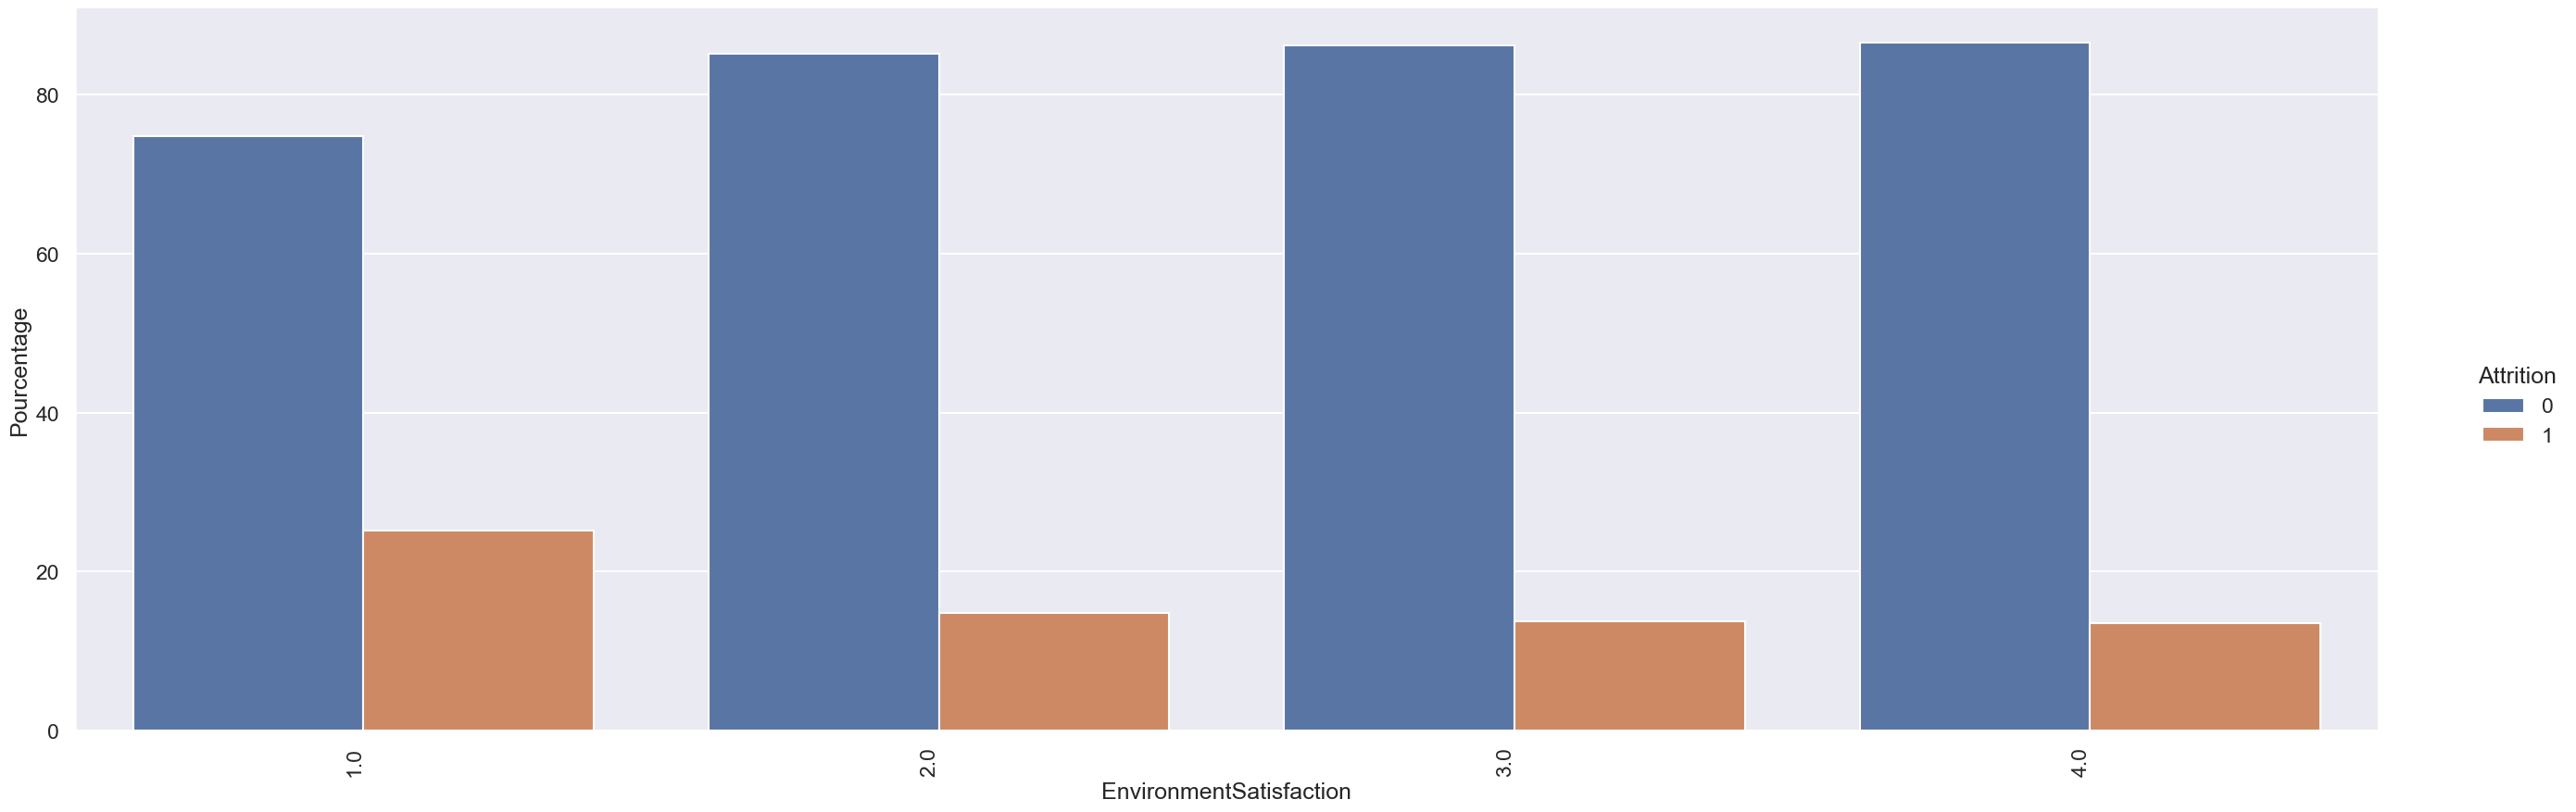

In [65]:
plot_mdi_values('EnvironmentSatisfaction')

**1/3** des employés ne sont pas sastifait de *l'environnement de travail*. Cela peut être dû au fait que les employés ne sont pas satisfaits de leur poste ou de leur salaire.

# Conclusion

Notre modèle Random Forest est capable de prédire avec une précision de **99.7%** si un employé va quitter l'entreprise ou non. Il est donc très performant et peut être utilisé pour aider à prévoir les départs d'employés. Il ne se trompera que très rarement et cela ne sera pas très grave car il ne faut pas oublier que le but de ce modèle est de prévenir les départs et non de les éviter. Il est donc très efficace pour ce travail de prévision.

Concernant les causes du départ d'un employé, nous avons pu identifier plusieurs de celles-ci :
- Le temps de travail moyen : **plus** le *temps de travail moyen* est élevé, **plus** l'employé est susceptible de quitter l'entreprise. Cela peut être dû au fait qu'il est plus fatigué et qu'il a moins de temps pour lui ou son entourage. Le contrat standard étant de 8h par jour, les personnes réalisant des heures supplémentaires peuvent être en surcharge de travail.  
- Le fait de voyager souvent : **plus** l'employé *voyage*, **plus** il est susceptible de quitter l'entreprise, peut être dû au fait qu'il est loin de son entourage et que les transports peuvent être à sa charge et fatiguant.  
- Le fait de travailler au service RH : Il serait nécessaire de faire une étude plus poussée sur ce point pour savoir pourquoi les RH sont les plus susceptibles de quitter l'entreprise.  
- L'âge : les employés les plus **jeunes** sont les plus susceptibles de quitter l'entreprise, il pourrait être intéressant de chercher des moyens de rendre l’entreprise ou les postes plus attractifs pour les jeunes.  
- Le fait de ne pas pouvoir combiner travail et vie personnelle : **plus** l'employé est *inconfortable* à combiner travail et vie personnelle, **plus** il est susceptible de quitter l'entreprise. Cela peut être dû au fait qu'il est fatigué et qu'il n'a pas le temps de faire ce qu'il veut chez lui à cause de temps passé au travail.  
- Le fait d'être satisfait de l'environnement de travail : **moins** l'employé est *satisfait* de l'environnement de travail, **plus** il est susceptible de quitter l'entreprise. Cela peut être dû au fait qu'il n'est pas satisfait de son poste ou de son salaire.